In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 100,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 831)
(631390, 1)
validation
(74368, 831)
(74368, 1)
test
(85358, 831)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


   1/6314 [..............................] - ETA: 1:43:03 - loss: 0.2581 - STD: 1.1943e-04 - MAE: 0.4995

  31/6314 [..............................] - ETA: 10s - loss: 0.0317 - STD: 1.2418e-04 - MAE: 0.1296    

  57/6314 [..............................] - ETA: 11s - loss: 0.0231 - STD: 8.6997e-05 - MAE: 0.1021

  83/6314 [..............................] - ETA: 11s - loss: 0.0199 - STD: 7.9217e-05 - MAE: 0.0921

 109/6314 [..............................] - ETA: 11s - loss: 0.0183 - STD: 9.0294e-05 - MAE: 0.0871

 136/6314 [..............................] - ETA: 11s - loss: 0.0174 - STD: 1.4441e-04 - MAE: 0.0845

 163/6314 [..............................] - ETA: 11s - loss: 0.0166 - STD: 3.8011e-04 - MAE: 0.0821

 188/6314 [..............................] - ETA: 11s - loss: 0.0159 - STD: 0.0014 - MAE: 0.0797    

 218/6314 [>.............................] - ETA: 11s - loss: 0.0149 - STD: 0.0064 - MAE: 0.0764

 242/6314 [>.............................] - ETA: 11s - loss: 0.0138 - STD: 0.0137 - MAE: 0.0729

 279/6314 [>.............................] - ETA: 11s - loss: 0.0124 - STD: 0.0241 - MAE: 0.0681

 317/6314 [>.............................] - ETA: 10s - loss: 0.0113 - STD: 0.0328 - MAE: 0.0641

 357/6314 [>.............................] - ETA: 10s - loss: 0.0103 - STD: 0.0399 - MAE: 0.0609

 395/6314 [>.............................] - ETA: 9s - loss: 0.0095 - STD: 0.0455 - MAE: 0.0581 

 437/6314 [=>............................] - ETA: 9s - loss: 0.0088 - STD: 0.0503 - MAE: 0.0556

 478/6314 [=>............................] - ETA: 9s - loss: 0.0083 - STD: 0.0546 - MAE: 0.0536

 513/6314 [=>............................] - ETA: 9s - loss: 0.0078 - STD: 0.0577 - MAE: 0.0520

 549/6314 [=>............................] - ETA: 9s - loss: 0.0075 - STD: 0.0611 - MAE: 0.0506

 585/6314 [=>............................] - ETA: 8s - loss: 0.0071 - STD: 0.0636 - MAE: 0.0494

 622/6314 [=>............................] - ETA: 8s - loss: 0.0068 - STD: 0.0660 - MAE: 0.0484

 659/6314 [==>...........................] - ETA: 8s - loss: 0.0066 - STD: 0.0677 - MAE: 0.0475

 689/6314 [==>...........................] - ETA: 8s - loss: 0.0064 - STD: 0.0691 - MAE: 0.0468

 715/6314 [==>...........................] - ETA: 8s - loss: 0.0062 - STD: 0.0703 - MAE: 0.0463

 745/6314 [==>...........................] - ETA: 8s - loss: 0.0061 - STD: 0.0714 - MAE: 0.0456

 773/6314 [==>...........................] - ETA: 8s - loss: 0.0059 - STD: 0.0724 - MAE: 0.0450

 800/6314 [==>...........................] - ETA: 8s - loss: 0.0058 - STD: 0.0735 - MAE: 0.0445

 830/6314 [==>...........................] - ETA: 8s - loss: 0.0056 - STD: 0.0744 - MAE: 0.0439

 855/6314 [===>..........................] - ETA: 8s - loss: 0.0055 - STD: 0.0752 - MAE: 0.0435

 882/6314 [===>..........................] - ETA: 8s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0431

 915/6314 [===>..........................] - ETA: 8s - loss: 0.0053 - STD: 0.0771 - MAE: 0.0426

 946/6314 [===>..........................] - ETA: 8s - loss: 0.0052 - STD: 0.0779 - MAE: 0.0423

 973/6314 [===>..........................] - ETA: 8s - loss: 0.0051 - STD: 0.0784 - MAE: 0.0420

1014/6314 [===>..........................] - ETA: 8s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0415

1054/6314 [====>.........................] - ETA: 8s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0410

1094/6314 [====>.........................] - ETA: 8s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0406

1134/6314 [====>.........................] - ETA: 8s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0402

1174/6314 [====>.........................] - ETA: 8s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0398

1214/6314 [====>.........................] - ETA: 7s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0394

1254/6314 [====>.........................] - ETA: 7s - loss: 0.0043 - STD: 0.0836 - MAE: 0.0390

1296/6314 [=====>........................] - ETA: 7s - loss: 0.0043 - STD: 0.0840 - MAE: 0.0387

1338/6314 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0384

1371/6314 [=====>........................] - ETA: 7s - loss: 0.0041 - STD: 0.0850 - MAE: 0.0381

1404/6314 [=====>........................] - ETA: 7s - loss: 0.0041 - STD: 0.0855 - MAE: 0.0379

1436/6314 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0858 - MAE: 0.0377

1458/6314 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0859 - MAE: 0.0376

1487/6314 [======>.......................] - ETA: 7s - loss: 0.0039 - STD: 0.0863 - MAE: 0.0374

1525/6314 [======>.......................] - ETA: 7s - loss: 0.0039 - STD: 0.0869 - MAE: 0.0372

1564/6314 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0872 - MAE: 0.0370

1604/6314 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0877 - MAE: 0.0368

1644/6314 [======>.......................] - ETA: 7s - loss: 0.0037 - STD: 0.0881 - MAE: 0.0366

1683/6314 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0884 - MAE: 0.0364

1722/6314 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0888 - MAE: 0.0362

1756/6314 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0890 - MAE: 0.0361

1781/6314 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0891 - MAE: 0.0360

1808/6314 [=======>......................] - ETA: 6s - loss: 0.0035 - STD: 0.0894 - MAE: 0.0359

1837/6314 [=======>......................] - ETA: 6s - loss: 0.0035 - STD: 0.0896 - MAE: 0.0357

1869/6314 [=======>......................] - ETA: 6s - loss: 0.0035 - STD: 0.0898 - MAE: 0.0356

1899/6314 [========>.....................] - ETA: 6s - loss: 0.0034 - STD: 0.0901 - MAE: 0.0354

1929/6314 [========>.....................] - ETA: 6s - loss: 0.0034 - STD: 0.0903 - MAE: 0.0353

1959/6314 [========>.....................] - ETA: 6s - loss: 0.0034 - STD: 0.0904 - MAE: 0.0353

1995/6314 [========>.....................] - ETA: 6s - loss: 0.0034 - STD: 0.0906 - MAE: 0.0351

2023/6314 [========>.....................] - ETA: 6s - loss: 0.0033 - STD: 0.0907 - MAE: 0.0350

2049/6314 [========>.....................] - ETA: 6s - loss: 0.0033 - STD: 0.0908 - MAE: 0.0349

2080/6314 [========>.....................] - ETA: 6s - loss: 0.0033 - STD: 0.0910 - MAE: 0.0348

2116/6314 [=========>....................] - ETA: 6s - loss: 0.0033 - STD: 0.0911 - MAE: 0.0347

2154/6314 [=========>....................] - ETA: 6s - loss: 0.0032 - STD: 0.0914 - MAE: 0.0346

2185/6314 [=========>....................] - ETA: 6s - loss: 0.0032 - STD: 0.0915 - MAE: 0.0345

2213/6314 [=========>....................] - ETA: 6s - loss: 0.0032 - STD: 0.0916 - MAE: 0.0344

2238/6314 [=========>....................] - ETA: 6s - loss: 0.0032 - STD: 0.0917 - MAE: 0.0343

2262/6314 [=========>....................] - ETA: 6s - loss: 0.0032 - STD: 0.0918 - MAE: 0.0342

2287/6314 [=========>....................] - ETA: 6s - loss: 0.0031 - STD: 0.0919 - MAE: 0.0342

2314/6314 [=========>....................] - ETA: 6s - loss: 0.0031 - STD: 0.0921 - MAE: 0.0341

2345/6314 [==========>...................] - ETA: 6s - loss: 0.0031 - STD: 0.0922 - MAE: 0.0340

2379/6314 [==========>...................] - ETA: 6s - loss: 0.0031 - STD: 0.0923 - MAE: 0.0339

2405/6314 [==========>...................] - ETA: 6s - loss: 0.0031 - STD: 0.0925 - MAE: 0.0339

2434/6314 [==========>...................] - ETA: 6s - loss: 0.0030 - STD: 0.0927 - MAE: 0.0338

2465/6314 [==========>...................] - ETA: 6s - loss: 0.0030 - STD: 0.0929 - MAE: 0.0337

2493/6314 [==========>...................] - ETA: 5s - loss: 0.0030 - STD: 0.0930 - MAE: 0.0336

2519/6314 [==========>...................] - ETA: 5s - loss: 0.0030 - STD: 0.0930 - MAE: 0.0336

2547/6314 [===========>..................] - ETA: 5s - loss: 0.0030 - STD: 0.0932 - MAE: 0.0335

2578/6314 [===========>..................] - ETA: 5s - loss: 0.0030 - STD: 0.0932 - MAE: 0.0334

2602/6314 [===========>..................] - ETA: 5s - loss: 0.0030 - STD: 0.0933 - MAE: 0.0334

2629/6314 [===========>..................] - ETA: 5s - loss: 0.0029 - STD: 0.0934 - MAE: 0.0333

2656/6314 [===========>..................] - ETA: 5s - loss: 0.0029 - STD: 0.0935 - MAE: 0.0332

2687/6314 [===========>..................] - ETA: 5s - loss: 0.0029 - STD: 0.0936 - MAE: 0.0332

2723/6314 [===========>..................] - ETA: 5s - loss: 0.0029 - STD: 0.0937 - MAE: 0.0331

2765/6314 [============>.................] - ETA: 5s - loss: 0.0029 - STD: 0.0938 - MAE: 0.0330

2794/6314 [============>.................] - ETA: 5s - loss: 0.0029 - STD: 0.0939 - MAE: 0.0330

2818/6314 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0940 - MAE: 0.0329

2844/6314 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0941 - MAE: 0.0328

2883/6314 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0942 - MAE: 0.0327

2920/6314 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0943 - MAE: 0.0327

2959/6314 [=============>................] - ETA: 5s - loss: 0.0028 - STD: 0.0944 - MAE: 0.0326

2988/6314 [=============>................] - ETA: 5s - loss: 0.0028 - STD: 0.0945 - MAE: 0.0326

3015/6314 [=============>................] - ETA: 5s - loss: 0.0028 - STD: 0.0946 - MAE: 0.0325

3042/6314 [=============>................] - ETA: 5s - loss: 0.0028 - STD: 0.0947 - MAE: 0.0325

3071/6314 [=============>................] - ETA: 5s - loss: 0.0027 - STD: 0.0948 - MAE: 0.0324

3099/6314 [=============>................] - ETA: 5s - loss: 0.0027 - STD: 0.0948 - MAE: 0.0324

3133/6314 [=============>................] - ETA: 5s - loss: 0.0027 - STD: 0.0949 - MAE: 0.0323

3166/6314 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0323

3191/6314 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0322

3218/6314 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.0951 - MAE: 0.0322

3243/6314 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.0952 - MAE: 0.0321

3270/6314 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.0952 - MAE: 0.0321

3298/6314 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.0953 - MAE: 0.0320

3326/6314 [==============>...............] - ETA: 4s - loss: 0.0026 - STD: 0.0954 - MAE: 0.0320

3353/6314 [==============>...............] - ETA: 4s - loss: 0.0026 - STD: 0.0955 - MAE: 0.0320

3378/6314 [===============>..............] - ETA: 4s - loss: 0.0026 - STD: 0.0956 - MAE: 0.0320

3402/6314 [===============>..............] - ETA: 4s - loss: 0.0026 - STD: 0.0956 - MAE: 0.0319

3435/6314 [===============>..............] - ETA: 4s - loss: 0.0026 - STD: 0.0957 - MAE: 0.0319

3472/6314 [===============>..............] - ETA: 4s - loss: 0.0026 - STD: 0.0958 - MAE: 0.0318

3500/6314 [===============>..............] - ETA: 4s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0318

3528/6314 [===============>..............] - ETA: 4s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0318

3554/6314 [===============>..............] - ETA: 4s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0317

3582/6314 [================>.............] - ETA: 4s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0317

3610/6314 [================>.............] - ETA: 4s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0317

3641/6314 [================>.............] - ETA: 4s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0316

3668/6314 [================>.............] - ETA: 4s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0316

3695/6314 [================>.............] - ETA: 4s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0316

3721/6314 [================>.............] - ETA: 4s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0316

3753/6314 [================>.............] - ETA: 4s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0315

3779/6314 [================>.............] - ETA: 4s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0315

3806/6314 [=================>............] - ETA: 4s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0315

3833/6314 [=================>............] - ETA: 4s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0314

3862/6314 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0314

3889/6314 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0314

3916/6314 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0313

3944/6314 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0313

3976/6314 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0313

4008/6314 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0312

4036/6314 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0312

4061/6314 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0312

4088/6314 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0311

4116/6314 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0311

4143/6314 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0311

4170/6314 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0311

4196/6314 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0310

4223/6314 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0310

4251/6314 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0310

4277/6314 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0309

4306/6314 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0309

4337/6314 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0309

4365/6314 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0308

4390/6314 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0308

4417/6314 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0308

4452/6314 [====================>.........] - ETA: 3s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0308

4490/6314 [====================>.........] - ETA: 3s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0307

4528/6314 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0307

4559/6314 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0307

4586/6314 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0307

4616/6314 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0306

4643/6314 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0306

4670/6314 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0306

4699/6314 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0306

4733/6314 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0305

4771/6314 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0305

4810/6314 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0305

4845/6314 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0305

4883/6314 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0304

4922/6314 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0304

4956/6314 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0304

4998/6314 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0303

5039/6314 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0303

5069/6314 [=======================>......] - ETA: 2s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0303

5099/6314 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0303

5127/6314 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0302

5153/6314 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0302

5177/6314 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0302

5203/6314 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0302

5238/6314 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0302

5270/6314 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0301

5290/6314 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0301

5317/6314 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0301

5341/6314 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0301

5365/6314 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301

5392/6314 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301

5419/6314 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0300

5445/6314 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0300

5475/6314 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0300

5511/6314 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0300

5546/6314 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0300

5572/6314 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0300

5601/6314 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0299

5636/6314 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0299

5675/6314 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0299

5713/6314 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0299

5750/6314 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0298

5791/6314 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0298

5832/6314 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0298

5874/6314 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0298

5916/6314 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0298

5957/6314 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0297

5998/6314 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0297

6037/6314 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0297

6072/6314 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0297

6112/6314 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0297

6151/6314 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0297

6182/6314 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0297

6213/6314 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0296

6251/6314 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0296

6284/6314 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0296

6310/6314 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0296

6314/6314 [==============================] - 13s 2ms/step - loss: 0.0021 - STD: 0.0996 - MAE: 0.0296 - val_loss: 0.0016 - val_STD: 0.0691 - val_MAE: 0.0303


Epoch 2/10000


   1/6314 [..............................] - ETA: 1:53 - loss: 0.0030 - STD: 0.1024 - MAE: 0.0384

  27/6314 [..............................] - ETA: 12s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0289 

  53/6314 [..............................] - ETA: 12s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0271

  80/6314 [..............................] - ETA: 12s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0266

 117/6314 [..............................] - ETA: 10s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0263

 155/6314 [..............................] - ETA: 10s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0261

 182/6314 [..............................] - ETA: 10s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

 208/6314 [..............................] - ETA: 10s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0264

 235/6314 [>.............................] - ETA: 10s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0264

 269/6314 [>.............................] - ETA: 10s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0262

 299/6314 [>.............................] - ETA: 10s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0262

 325/6314 [>.............................] - ETA: 10s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0262

 354/6314 [>.............................] - ETA: 10s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0263

 380/6314 [>.............................] - ETA: 10s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0263

 414/6314 [>.............................] - ETA: 10s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0263

 455/6314 [=>............................] - ETA: 9s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0261 

 492/6314 [=>............................] - ETA: 9s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0262

 530/6314 [=>............................] - ETA: 9s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0261

 564/6314 [=>............................] - ETA: 9s - loss: 0.0014 - STD: 0.1036 - MAE: 0.0260

 594/6314 [=>............................] - ETA: 9s - loss: 0.0014 - STD: 0.1039 - MAE: 0.0260

 630/6314 [=>............................] - ETA: 9s - loss: 0.0014 - STD: 0.1041 - MAE: 0.0259

 664/6314 [==>...........................] - ETA: 9s - loss: 0.0014 - STD: 0.1039 - MAE: 0.0259

 699/6314 [==>...........................] - ETA: 9s - loss: 0.0014 - STD: 0.1039 - MAE: 0.0259

 739/6314 [==>...........................] - ETA: 8s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0259

 773/6314 [==>...........................] - ETA: 8s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0259

 796/6314 [==>...........................] - ETA: 8s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0259

 832/6314 [==>...........................] - ETA: 8s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0259

 866/6314 [===>..........................] - ETA: 8s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0259

 892/6314 [===>..........................] - ETA: 8s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0259

 919/6314 [===>..........................] - ETA: 8s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0259

 947/6314 [===>..........................] - ETA: 8s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0258

 979/6314 [===>..........................] - ETA: 8s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0259

1010/6314 [===>..........................] - ETA: 8s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0258

1038/6314 [===>..........................] - ETA: 8s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0258

1064/6314 [====>.........................] - ETA: 8s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0258

1092/6314 [====>.........................] - ETA: 8s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0258

1117/6314 [====>.........................] - ETA: 8s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0258

1155/6314 [====>.........................] - ETA: 8s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0258

1192/6314 [====>.........................] - ETA: 8s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0258

1228/6314 [====>.........................] - ETA: 8s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0258

1264/6314 [=====>........................] - ETA: 8s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0258

1305/6314 [=====>........................] - ETA: 8s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0258

1345/6314 [=====>........................] - ETA: 7s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0258

1383/6314 [=====>........................] - ETA: 7s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0258

1421/6314 [=====>........................] - ETA: 7s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0258

1459/6314 [=====>........................] - ETA: 7s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0258

1498/6314 [======>.......................] - ETA: 7s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0258

1535/6314 [======>.......................] - ETA: 7s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0257

1575/6314 [======>.......................] - ETA: 7s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0257

1612/6314 [======>.......................] - ETA: 7s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0257

1651/6314 [======>.......................] - ETA: 7s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0257

1689/6314 [=======>......................] - ETA: 7s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0256

1725/6314 [=======>......................] - ETA: 7s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0256

1758/6314 [=======>......................] - ETA: 6s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0256

1794/6314 [=======>......................] - ETA: 6s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0256

1831/6314 [=======>......................] - ETA: 6s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0256

1868/6314 [=======>......................] - ETA: 6s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0256

1905/6314 [========>.....................] - ETA: 6s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0256

1936/6314 [========>.....................] - ETA: 6s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0256

1965/6314 [========>.....................] - ETA: 6s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0256

2003/6314 [========>.....................] - ETA: 6s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0256

2032/6314 [========>.....................] - ETA: 6s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0255

2069/6314 [========>.....................] - ETA: 6s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0255

2107/6314 [=========>....................] - ETA: 6s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0255

2143/6314 [=========>....................] - ETA: 6s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0255

2182/6314 [=========>....................] - ETA: 6s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0255

2218/6314 [=========>....................] - ETA: 6s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0255

2257/6314 [=========>....................] - ETA: 6s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0255

2293/6314 [=========>....................] - ETA: 6s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0255

2333/6314 [==========>...................] - ETA: 5s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0255

2366/6314 [==========>...................] - ETA: 5s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0255

2400/6314 [==========>...................] - ETA: 5s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0255

2439/6314 [==========>...................] - ETA: 5s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0254

2476/6314 [==========>...................] - ETA: 5s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0255

2511/6314 [==========>...................] - ETA: 5s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0254

2548/6314 [===========>..................] - ETA: 5s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0254

2585/6314 [===========>..................] - ETA: 5s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0254

2618/6314 [===========>..................] - ETA: 5s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0254

2653/6314 [===========>..................] - ETA: 5s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0254

2687/6314 [===========>..................] - ETA: 5s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0254

2725/6314 [===========>..................] - ETA: 5s - loss: 0.0014 - STD: 0.1041 - MAE: 0.0254

2765/6314 [============>.................] - ETA: 5s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0254

2800/6314 [============>.................] - ETA: 5s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0254

2829/6314 [============>.................] - ETA: 5s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0254

2862/6314 [============>.................] - ETA: 5s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0254

2894/6314 [============>.................] - ETA: 5s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0254

2930/6314 [============>.................] - ETA: 5s - loss: 0.0014 - STD: 0.1041 - MAE: 0.0254

2958/6314 [=============>................] - ETA: 5s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0254

2995/6314 [=============>................] - ETA: 4s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0254

3036/6314 [=============>................] - ETA: 4s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0254

3073/6314 [=============>................] - ETA: 4s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0254

3112/6314 [=============>................] - ETA: 4s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0254

3142/6314 [=============>................] - ETA: 4s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0254

3171/6314 [==============>...............] - ETA: 4s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0254

3206/6314 [==============>...............] - ETA: 4s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0254

3242/6314 [==============>...............] - ETA: 4s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0254

3278/6314 [==============>...............] - ETA: 4s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0254

3308/6314 [==============>...............] - ETA: 4s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0254

3347/6314 [==============>...............] - ETA: 4s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0254

3390/6314 [===============>..............] - ETA: 4s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0254

3432/6314 [===============>..............] - ETA: 4s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0254

3474/6314 [===============>..............] - ETA: 4s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0254

3511/6314 [===============>..............] - ETA: 4s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0254

3543/6314 [===============>..............] - ETA: 4s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0254

3572/6314 [===============>..............] - ETA: 4s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0254

3600/6314 [================>.............] - ETA: 4s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0254

3633/6314 [================>.............] - ETA: 3s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0254

3673/6314 [================>.............] - ETA: 3s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0254

3713/6314 [================>.............] - ETA: 3s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0253

3755/6314 [================>.............] - ETA: 3s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0253

3794/6314 [=================>............] - ETA: 3s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0253

3836/6314 [=================>............] - ETA: 3s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

3877/6314 [=================>............] - ETA: 3s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

3917/6314 [=================>............] - ETA: 3s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

3958/6314 [=================>............] - ETA: 3s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

3996/6314 [=================>............] - ETA: 3s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

4031/6314 [==================>...........] - ETA: 3s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

4069/6314 [==================>...........] - ETA: 3s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

4107/6314 [==================>...........] - ETA: 3s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

4144/6314 [==================>...........] - ETA: 3s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

4181/6314 [==================>...........] - ETA: 3s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

4219/6314 [===================>..........] - ETA: 3s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

4255/6314 [===================>..........] - ETA: 2s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

4292/6314 [===================>..........] - ETA: 2s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

4326/6314 [===================>..........] - ETA: 2s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

4352/6314 [===================>..........] - ETA: 2s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

4379/6314 [===================>..........] - ETA: 2s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

4401/6314 [===================>..........] - ETA: 2s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

4426/6314 [====================>.........] - ETA: 2s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

4452/6314 [====================>.........] - ETA: 2s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

4479/6314 [====================>.........] - ETA: 2s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

4506/6314 [====================>.........] - ETA: 2s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

4541/6314 [====================>.........] - ETA: 2s - loss: 0.0013 - STD: 0.1044 - MAE: 0.0252

4578/6314 [====================>.........] - ETA: 2s - loss: 0.0013 - STD: 0.1044 - MAE: 0.0252

4612/6314 [====================>.........] - ETA: 2s - loss: 0.0013 - STD: 0.1044 - MAE: 0.0252

4652/6314 [=====================>........] - ETA: 2s - loss: 0.0013 - STD: 0.1044 - MAE: 0.0252

4694/6314 [=====================>........] - ETA: 2s - loss: 0.0013 - STD: 0.1044 - MAE: 0.0252

4735/6314 [=====================>........] - ETA: 2s - loss: 0.0013 - STD: 0.1044 - MAE: 0.0252

4773/6314 [=====================>........] - ETA: 2s - loss: 0.0013 - STD: 0.1044 - MAE: 0.0252

4810/6314 [=====================>........] - ETA: 2s - loss: 0.0013 - STD: 0.1044 - MAE: 0.0252

4848/6314 [======================>.......] - ETA: 2s - loss: 0.0013 - STD: 0.1044 - MAE: 0.0252

4885/6314 [======================>.......] - ETA: 2s - loss: 0.0013 - STD: 0.1044 - MAE: 0.0252

4921/6314 [======================>.......] - ETA: 2s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0251

4956/6314 [======================>.......] - ETA: 1s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0251

4991/6314 [======================>.......] - ETA: 1s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0251

5027/6314 [======================>.......] - ETA: 1s - loss: 0.0013 - STD: 0.1044 - MAE: 0.0251

5059/6314 [=======================>......] - ETA: 1s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0251

5091/6314 [=======================>......] - ETA: 1s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0251

5127/6314 [=======================>......] - ETA: 1s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0251

5162/6314 [=======================>......] - ETA: 1s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0251

5197/6314 [=======================>......] - ETA: 1s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0251

5230/6314 [=======================>......] - ETA: 1s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0251

5265/6314 [========================>.....] - ETA: 1s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0251

5301/6314 [========================>.....] - ETA: 1s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0251

5340/6314 [========================>.....] - ETA: 1s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0251

5375/6314 [========================>.....] - ETA: 1s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0251

5410/6314 [========================>.....] - ETA: 1s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0251

5447/6314 [========================>.....] - ETA: 1s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0251

5480/6314 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0251

5516/6314 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0251

5553/6314 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0250

5590/6314 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0250

5620/6314 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0250

5646/6314 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1047 - MAE: 0.0250

5679/6314 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1047 - MAE: 0.0250

5705/6314 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1047 - MAE: 0.0250

5729/6314 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1047 - MAE: 0.0250

5755/6314 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

5780/6314 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

5808/6314 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

5835/6314 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

5865/6314 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

5893/6314 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

5919/6314 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

5950/6314 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

5979/6314 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

6006/6314 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

6034/6314 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

6063/6314 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

6088/6314 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

6115/6314 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

6143/6314 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

6176/6314 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

6202/6314 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

6230/6314 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

6259/6314 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

6284/6314 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

6307/6314 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

6314/6314 [==============================] - 10s 2ms/step - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250 - val_loss: 0.0015 - val_STD: 0.0744 - val_MAE: 0.0265


Epoch 3/10000


   1/6314 [..............................] - ETA: 1:50 - loss: 0.0011 - STD: 0.1054 - MAE: 0.0240

  37/6314 [..............................] - ETA: 8s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0232  

  78/6314 [..............................] - ETA: 8s - loss: 0.0012 - STD: 0.1059 - MAE: 0.0234

 116/6314 [..............................] - ETA: 8s - loss: 0.0012 - STD: 0.1051 - MAE: 0.0238

 153/6314 [..............................] - ETA: 8s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0241

 191/6314 [..............................] - ETA: 8s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0241

 229/6314 [>.............................] - ETA: 8s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

 266/6314 [>.............................] - ETA: 8s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

 306/6314 [>.............................] - ETA: 8s - loss: 0.0012 - STD: 0.1060 - MAE: 0.0241

 346/6314 [>.............................] - ETA: 7s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0242

 385/6314 [>.............................] - ETA: 7s - loss: 0.0012 - STD: 0.1060 - MAE: 0.0242

 427/6314 [=>............................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0242

 468/6314 [=>............................] - ETA: 7s - loss: 0.0012 - STD: 0.1059 - MAE: 0.0242

 508/6314 [=>............................] - ETA: 7s - loss: 0.0012 - STD: 0.1059 - MAE: 0.0242

 547/6314 [=>............................] - ETA: 7s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0243

 585/6314 [=>............................] - ETA: 7s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0242

 627/6314 [=>............................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0242

 669/6314 [==>...........................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0242

 710/6314 [==>...........................] - ETA: 7s - loss: 0.0012 - STD: 0.1059 - MAE: 0.0241

 751/6314 [==>...........................] - ETA: 7s - loss: 0.0012 - STD: 0.1060 - MAE: 0.0241

 792/6314 [==>...........................] - ETA: 7s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0241

 832/6314 [==>...........................] - ETA: 7s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0242

 873/6314 [===>..........................] - ETA: 6s - loss: 0.0012 - STD: 0.1059 - MAE: 0.0241

 914/6314 [===>..........................] - ETA: 6s - loss: 0.0012 - STD: 0.1060 - MAE: 0.0241

 950/6314 [===>..........................] - ETA: 6s - loss: 0.0012 - STD: 0.1059 - MAE: 0.0241

 987/6314 [===>..........................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0241

1028/6314 [===>..........................] - ETA: 6s - loss: 0.0012 - STD: 0.1060 - MAE: 0.0241

1066/6314 [====>.........................] - ETA: 6s - loss: 0.0012 - STD: 0.1059 - MAE: 0.0241

1106/6314 [====>.........................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0241

1146/6314 [====>.........................] - ETA: 6s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0241

1187/6314 [====>.........................] - ETA: 6s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0241

1228/6314 [====>.........................] - ETA: 6s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0241

1269/6314 [=====>........................] - ETA: 6s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0241

1308/6314 [=====>........................] - ETA: 6s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0241

1349/6314 [=====>........................] - ETA: 6s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0241

1388/6314 [=====>........................] - ETA: 6s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0241

1429/6314 [=====>........................] - ETA: 6s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0241

1470/6314 [=====>........................] - ETA: 6s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0241

1510/6314 [======>.......................] - ETA: 6s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0241

1542/6314 [======>.......................] - ETA: 6s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0241

1567/6314 [======>.......................] - ETA: 6s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0241

1595/6314 [======>.......................] - ETA: 6s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0241

1624/6314 [======>.......................] - ETA: 6s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0241

1656/6314 [======>.......................] - ETA: 6s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0240

1698/6314 [=======>......................] - ETA: 6s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0241

1731/6314 [=======>......................] - ETA: 6s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0240

1754/6314 [=======>......................] - ETA: 6s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0240

1779/6314 [=======>......................] - ETA: 6s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0240

1815/6314 [=======>......................] - ETA: 6s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0240

1850/6314 [=======>......................] - ETA: 5s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0240

1890/6314 [=======>......................] - ETA: 5s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0240

1932/6314 [========>.....................] - ETA: 5s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0240

1975/6314 [========>.....................] - ETA: 5s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0241

2015/6314 [========>.....................] - ETA: 5s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0241

2052/6314 [========>.....................] - ETA: 5s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0241

2091/6314 [========>.....................] - ETA: 5s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0241

2131/6314 [=========>....................] - ETA: 5s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0241

2158/6314 [=========>....................] - ETA: 5s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0241

2188/6314 [=========>....................] - ETA: 5s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0241

2215/6314 [=========>....................] - ETA: 5s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0241

2241/6314 [=========>....................] - ETA: 5s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0241

2266/6314 [=========>....................] - ETA: 5s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0241

2290/6314 [=========>....................] - ETA: 5s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0241

2317/6314 [==========>...................] - ETA: 5s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0240

2343/6314 [==========>...................] - ETA: 5s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0240

2370/6314 [==========>...................] - ETA: 5s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0240

2402/6314 [==========>...................] - ETA: 5s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0240

2436/6314 [==========>...................] - ETA: 5s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0240

2466/6314 [==========>...................] - ETA: 5s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0240

2502/6314 [==========>...................] - ETA: 5s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

2541/6314 [===========>..................] - ETA: 5s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0240

2580/6314 [===========>..................] - ETA: 5s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

2620/6314 [===========>..................] - ETA: 5s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

2656/6314 [===========>..................] - ETA: 5s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

2684/6314 [===========>..................] - ETA: 5s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

2723/6314 [===========>..................] - ETA: 5s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

2764/6314 [============>.................] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

2805/6314 [============>.................] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

2837/6314 [============>.................] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

2867/6314 [============>.................] - ETA: 4s - loss: 0.0012 - STD: 0.1052 - MAE: 0.0240

2891/6314 [============>.................] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

2920/6314 [============>.................] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

2946/6314 [============>.................] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

2979/6314 [=============>................] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

3005/6314 [=============>................] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

3039/6314 [=============>................] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

3072/6314 [=============>................] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

3108/6314 [=============>................] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

3148/6314 [=============>................] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

3184/6314 [==============>...............] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

3226/6314 [==============>...............] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

3268/6314 [==============>...............] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

3308/6314 [==============>...............] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

3349/6314 [==============>...............] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

3387/6314 [===============>..............] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0239

3423/6314 [===============>..............] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0239

3459/6314 [===============>..............] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0239

3497/6314 [===============>..............] - ETA: 3s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0239

3532/6314 [===============>..............] - ETA: 3s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0239

3571/6314 [===============>..............] - ETA: 3s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0239

3610/6314 [================>.............] - ETA: 3s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0239

3647/6314 [================>.............] - ETA: 3s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0239

3685/6314 [================>.............] - ETA: 3s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0239

3722/6314 [================>.............] - ETA: 3s - loss: 0.0012 - STD: 0.1052 - MAE: 0.0239

3758/6314 [================>.............] - ETA: 3s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0239

3795/6314 [=================>............] - ETA: 3s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0239

3833/6314 [=================>............] - ETA: 3s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0239

3869/6314 [=================>............] - ETA: 3s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0239

3906/6314 [=================>............] - ETA: 3s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0239

3943/6314 [=================>............] - ETA: 3s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0239

3973/6314 [=================>............] - ETA: 3s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0239

4004/6314 [==================>...........] - ETA: 3s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0239

4029/6314 [==================>...........] - ETA: 3s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0239

4054/6314 [==================>...........] - ETA: 3s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0239

4079/6314 [==================>...........] - ETA: 3s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0239

4107/6314 [==================>...........] - ETA: 3s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0239

4135/6314 [==================>...........] - ETA: 3s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0239

4160/6314 [==================>...........] - ETA: 3s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0239

4188/6314 [==================>...........] - ETA: 3s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4226/6314 [===================>..........] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4255/6314 [===================>..........] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4289/6314 [===================>..........] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4318/6314 [===================>..........] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4343/6314 [===================>..........] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4370/6314 [===================>..........] - ETA: 2s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0238

4393/6314 [===================>..........] - ETA: 2s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0238

4418/6314 [===================>..........] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4447/6314 [====================>.........] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4472/6314 [====================>.........] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4497/6314 [====================>.........] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4522/6314 [====================>.........] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4546/6314 [====================>.........] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4578/6314 [====================>.........] - ETA: 2s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0238

4615/6314 [====================>.........] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4645/6314 [=====================>........] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4670/6314 [=====================>........] - ETA: 2s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0238

4695/6314 [=====================>........] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4722/6314 [=====================>........] - ETA: 2s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0238

4746/6314 [=====================>........] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4774/6314 [=====================>........] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4807/6314 [=====================>........] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4840/6314 [=====================>........] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4871/6314 [======================>.......] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4898/6314 [======================>.......] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4932/6314 [======================>.......] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4959/6314 [======================>.......] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

4984/6314 [======================>.......] - ETA: 1s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

5017/6314 [======================>.......] - ETA: 1s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

5058/6314 [=======================>......] - ETA: 1s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

5097/6314 [=======================>......] - ETA: 1s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

5138/6314 [=======================>......] - ETA: 1s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

5178/6314 [=======================>......] - ETA: 1s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

5219/6314 [=======================>......] - ETA: 1s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

5260/6314 [=======================>......] - ETA: 1s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

5300/6314 [========================>.....] - ETA: 1s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0238

5341/6314 [========================>.....] - ETA: 1s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0237

5381/6314 [========================>.....] - ETA: 1s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0237

5421/6314 [========================>.....] - ETA: 1s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0237

5461/6314 [========================>.....] - ETA: 1s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0237

5502/6314 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0237

5540/6314 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0237

5579/6314 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0237

5618/6314 [=========================>....] - ETA: 1s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0237

5658/6314 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0237

5697/6314 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0237

5732/6314 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0237

5769/6314 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0237

5805/6314 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0237

5841/6314 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0237

5879/6314 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0237

5915/6314 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0237

5953/6314 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0237

5991/6314 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0237

6031/6314 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0237

6062/6314 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0237

6095/6314 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0237

6134/6314 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0237

6172/6314 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0237

6213/6314 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0237

6252/6314 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0237

6292/6314 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0237

6314/6314 [==============================] - 10s 2ms/step - loss: 0.0012 - STD: 0.1055 - MAE: 0.0237 - val_loss: 0.0016 - val_STD: 0.0711 - val_MAE: 0.0266


Epoch 4/10000


   1/6314 [..............................] - ETA: 1:52 - loss: 0.0010 - STD: 0.0975 - MAE: 0.0222

  33/6314 [..............................] - ETA: 10s - loss: 0.0012 - STD: 0.1022 - MAE: 0.0236 

  67/6314 [..............................] - ETA: 9s - loss: 0.0011 - STD: 0.1045 - MAE: 0.0232 

 103/6314 [..............................] - ETA: 9s - loss: 0.0011 - STD: 0.1039 - MAE: 0.0230

 140/6314 [..............................] - ETA: 9s - loss: 0.0011 - STD: 0.1042 - MAE: 0.0232

 179/6314 [..............................] - ETA: 8s - loss: 0.0011 - STD: 0.1047 - MAE: 0.0232

 217/6314 [>.............................] - ETA: 8s - loss: 0.0011 - STD: 0.1049 - MAE: 0.0232

 255/6314 [>.............................] - ETA: 8s - loss: 0.0011 - STD: 0.1048 - MAE: 0.0230

 289/6314 [>.............................] - ETA: 8s - loss: 0.0011 - STD: 0.1050 - MAE: 0.0230

 324/6314 [>.............................] - ETA: 8s - loss: 0.0011 - STD: 0.1049 - MAE: 0.0231

 361/6314 [>.............................] - ETA: 8s - loss: 0.0011 - STD: 0.1050 - MAE: 0.0231

 400/6314 [>.............................] - ETA: 8s - loss: 0.0011 - STD: 0.1051 - MAE: 0.0231

 438/6314 [=>............................] - ETA: 8s - loss: 0.0011 - STD: 0.1048 - MAE: 0.0232

 475/6314 [=>............................] - ETA: 8s - loss: 0.0011 - STD: 0.1048 - MAE: 0.0232

 511/6314 [=>............................] - ETA: 8s - loss: 0.0011 - STD: 0.1049 - MAE: 0.0231

 547/6314 [=>............................] - ETA: 8s - loss: 0.0011 - STD: 0.1048 - MAE: 0.0231

 582/6314 [=>............................] - ETA: 8s - loss: 0.0011 - STD: 0.1050 - MAE: 0.0230

 618/6314 [=>............................] - ETA: 7s - loss: 0.0011 - STD: 0.1048 - MAE: 0.0230

 651/6314 [==>...........................] - ETA: 7s - loss: 0.0011 - STD: 0.1051 - MAE: 0.0231

 687/6314 [==>...........................] - ETA: 7s - loss: 0.0011 - STD: 0.1051 - MAE: 0.0231

 724/6314 [==>...........................] - ETA: 7s - loss: 0.0011 - STD: 0.1053 - MAE: 0.0230

 758/6314 [==>...........................] - ETA: 7s - loss: 0.0011 - STD: 0.1052 - MAE: 0.0230

 796/6314 [==>...........................] - ETA: 7s - loss: 0.0011 - STD: 0.1051 - MAE: 0.0230

 837/6314 [==>...........................] - ETA: 7s - loss: 0.0011 - STD: 0.1050 - MAE: 0.0230

 876/6314 [===>..........................] - ETA: 7s - loss: 0.0011 - STD: 0.1050 - MAE: 0.0230

 915/6314 [===>..........................] - ETA: 7s - loss: 0.0011 - STD: 0.1050 - MAE: 0.0230

 956/6314 [===>..........................] - ETA: 7s - loss: 0.0011 - STD: 0.1050 - MAE: 0.0230

 998/6314 [===>..........................] - ETA: 7s - loss: 0.0011 - STD: 0.1049 - MAE: 0.0230

1040/6314 [===>..........................] - ETA: 7s - loss: 0.0011 - STD: 0.1052 - MAE: 0.0230

1077/6314 [====>.........................] - ETA: 7s - loss: 0.0011 - STD: 0.1053 - MAE: 0.0231

1116/6314 [====>.........................] - ETA: 7s - loss: 0.0011 - STD: 0.1053 - MAE: 0.0230

1154/6314 [====>.........................] - ETA: 7s - loss: 0.0011 - STD: 0.1052 - MAE: 0.0230

1192/6314 [====>.........................] - ETA: 6s - loss: 0.0011 - STD: 0.1053 - MAE: 0.0230

1227/6314 [====>.........................] - ETA: 6s - loss: 0.0011 - STD: 0.1053 - MAE: 0.0230

1262/6314 [====>.........................] - ETA: 6s - loss: 0.0011 - STD: 0.1053 - MAE: 0.0230

1299/6314 [=====>........................] - ETA: 6s - loss: 0.0011 - STD: 0.1054 - MAE: 0.0230

1334/6314 [=====>........................] - ETA: 6s - loss: 0.0011 - STD: 0.1055 - MAE: 0.0230

1369/6314 [=====>........................] - ETA: 6s - loss: 0.0011 - STD: 0.1055 - MAE: 0.0230

1404/6314 [=====>........................] - ETA: 6s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0230

1443/6314 [=====>........................] - ETA: 6s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0230

1479/6314 [======>.......................] - ETA: 6s - loss: 0.0011 - STD: 0.1055 - MAE: 0.0230

1515/6314 [======>.......................] - ETA: 6s - loss: 0.0011 - STD: 0.1055 - MAE: 0.0230

1552/6314 [======>.......................] - ETA: 6s - loss: 0.0011 - STD: 0.1055 - MAE: 0.0230

1590/6314 [======>.......................] - ETA: 6s - loss: 0.0011 - STD: 0.1055 - MAE: 0.0230

1627/6314 [======>.......................] - ETA: 6s - loss: 0.0011 - STD: 0.1055 - MAE: 0.0230

1664/6314 [======>.......................] - ETA: 6s - loss: 0.0011 - STD: 0.1055 - MAE: 0.0230

1702/6314 [=======>......................] - ETA: 6s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0230

1740/6314 [=======>......................] - ETA: 6s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0230

1777/6314 [=======>......................] - ETA: 6s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0230

1817/6314 [=======>......................] - ETA: 6s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0230

1857/6314 [=======>......................] - ETA: 6s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0230

1893/6314 [=======>......................] - ETA: 6s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0230

1927/6314 [========>.....................] - ETA: 6s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0230

1962/6314 [========>.....................] - ETA: 5s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0229

1996/6314 [========>.....................] - ETA: 5s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0229

2033/6314 [========>.....................] - ETA: 5s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0230

2070/6314 [========>.....................] - ETA: 5s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0230

2110/6314 [=========>....................] - ETA: 5s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0230

2151/6314 [=========>....................] - ETA: 5s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0230

2192/6314 [=========>....................] - ETA: 5s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0230

2230/6314 [=========>....................] - ETA: 5s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0230

2269/6314 [=========>....................] - ETA: 5s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0230

2305/6314 [=========>....................] - ETA: 5s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0230

2343/6314 [==========>...................] - ETA: 5s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0230

2382/6314 [==========>...................] - ETA: 5s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0230

2420/6314 [==========>...................] - ETA: 5s - loss: 0.0011 - STD: 0.1055 - MAE: 0.0230

2460/6314 [==========>...................] - ETA: 5s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0230

2498/6314 [==========>...................] - ETA: 5s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0229

2532/6314 [===========>..................] - ETA: 5s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0230

2563/6314 [===========>..................] - ETA: 5s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0230

2599/6314 [===========>..................] - ETA: 5s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0230

2638/6314 [===========>..................] - ETA: 5s - loss: 0.0011 - STD: 0.1055 - MAE: 0.0230

2677/6314 [===========>..................] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0229

2714/6314 [===========>..................] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0229

2750/6314 [============>.................] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0229

2788/6314 [============>.................] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0229

2823/6314 [============>.................] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0229

2860/6314 [============>.................] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0229

2897/6314 [============>.................] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0229

2934/6314 [============>.................] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0229

2971/6314 [=============>................] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0229

3007/6314 [=============>................] - ETA: 4s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0229

3043/6314 [=============>................] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0229

3079/6314 [=============>................] - ETA: 4s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0229

3115/6314 [=============>................] - ETA: 4s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0229

3148/6314 [=============>................] - ETA: 4s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0229

3186/6314 [==============>...............] - ETA: 4s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0229

3222/6314 [==============>...............] - ETA: 4s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0229

3256/6314 [==============>...............] - ETA: 4s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0229

3292/6314 [==============>...............] - ETA: 4s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0229

3326/6314 [==============>...............] - ETA: 4s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0229

3363/6314 [==============>...............] - ETA: 4s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0229

3403/6314 [===============>..............] - ETA: 3s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0229

3438/6314 [===============>..............] - ETA: 3s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0229

3476/6314 [===============>..............] - ETA: 3s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0228

3514/6314 [===============>..............] - ETA: 3s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0228

3552/6314 [===============>..............] - ETA: 3s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0228

3590/6314 [================>.............] - ETA: 3s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0228

3630/6314 [================>.............] - ETA: 3s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0228

3669/6314 [================>.............] - ETA: 3s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0228

3699/6314 [================>.............] - ETA: 3s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0228

3723/6314 [================>.............] - ETA: 3s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0228

3748/6314 [================>.............] - ETA: 3s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0228

3776/6314 [================>.............] - ETA: 3s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0228

3803/6314 [=================>............] - ETA: 3s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0228

3830/6314 [=================>............] - ETA: 3s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0228

3858/6314 [=================>............] - ETA: 3s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0228

3885/6314 [=================>............] - ETA: 3s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0228

3909/6314 [=================>............] - ETA: 3s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0228

3937/6314 [=================>............] - ETA: 3s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0228

3962/6314 [=================>............] - ETA: 3s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0228

3987/6314 [=================>............] - ETA: 3s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0228

4011/6314 [==================>...........] - ETA: 3s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0228

4040/6314 [==================>...........] - ETA: 3s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0228

4077/6314 [==================>...........] - ETA: 3s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0228

4106/6314 [==================>...........] - ETA: 3s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0228

4133/6314 [==================>...........] - ETA: 3s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0228

4163/6314 [==================>...........] - ETA: 3s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0228

4200/6314 [==================>...........] - ETA: 3s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0228

4237/6314 [===================>..........] - ETA: 2s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0228

4275/6314 [===================>..........] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0228

4309/6314 [===================>..........] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0228

4344/6314 [===================>..........] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0228

4379/6314 [===================>..........] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0228

4415/6314 [===================>..........] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0228

4451/6314 [====================>.........] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0228

4490/6314 [====================>.........] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0228

4528/6314 [====================>.........] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0228

4566/6314 [====================>.........] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0228

4605/6314 [====================>.........] - ETA: 2s - loss: 0.0011 - STD: 0.1061 - MAE: 0.0228

4642/6314 [=====================>........] - ETA: 2s - loss: 0.0011 - STD: 0.1061 - MAE: 0.0228

4682/6314 [=====================>........] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0228

4718/6314 [=====================>........] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0228

4756/6314 [=====================>........] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0228

4794/6314 [=====================>........] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0228

4834/6314 [=====================>........] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0228

4875/6314 [======================>.......] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0228

4915/6314 [======================>.......] - ETA: 1s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0228

4954/6314 [======================>.......] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0228

4991/6314 [======================>.......] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0228

5027/6314 [======================>.......] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0228

5058/6314 [=======================>......] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0228

5091/6314 [=======================>......] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0228

5132/6314 [=======================>......] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0228

5158/6314 [=======================>......] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0228

5182/6314 [=======================>......] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0228

5209/6314 [=======================>......] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0228

5237/6314 [=======================>......] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5265/6314 [========================>.....] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5294/6314 [========================>.....] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5324/6314 [========================>.....] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5365/6314 [========================>.....] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5404/6314 [========================>.....] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5435/6314 [========================>.....] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5462/6314 [========================>.....] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5490/6314 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5517/6314 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5543/6314 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5570/6314 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5603/6314 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5630/6314 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5666/6314 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5691/6314 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5717/6314 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5747/6314 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5778/6314 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5815/6314 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5851/6314 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5875/6314 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5897/6314 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5929/6314 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

5957/6314 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0227

5989/6314 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

6029/6314 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

6070/6314 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

6104/6314 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0227

6142/6314 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0227

6174/6314 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

6214/6314 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

6253/6314 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0227

6284/6314 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0227

6314/6314 [==============================] - 10s 2ms/step - loss: 0.0011 - STD: 0.1060 - MAE: 0.0227 - val_loss: 0.0022 - val_STD: 0.0735 - val_MAE: 0.0308


Epoch 5/10000


   1/6314 [..............................] - ETA: 1:40 - loss: 9.5843e-04 - STD: 0.1118 - MAE: 0.0226

  27/6314 [..............................] - ETA: 12s - loss: 9.8148e-04 - STD: 0.1043 - MAE: 0.0221 

  51/6314 [..............................] - ETA: 12s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0223    

  78/6314 [..............................] - ETA: 12s - loss: 0.0010 - STD: 0.1069 - MAE: 0.0223

 109/6314 [..............................] - ETA: 11s - loss: 9.8817e-04 - STD: 0.1056 - MAE: 0.0221

 147/6314 [..............................] - ETA: 10s - loss: 0.0010 - STD: 0.1055 - MAE: 0.0224    

 184/6314 [..............................] - ETA: 10s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

 222/6314 [>.............................] - ETA: 9s - loss: 0.0010 - STD: 0.1058 - MAE: 0.0224 

 258/6314 [>.............................] - ETA: 9s - loss: 0.0010 - STD: 0.1057 - MAE: 0.0224

 293/6314 [>.............................] - ETA: 9s - loss: 0.0010 - STD: 0.1060 - MAE: 0.0226

 323/6314 [>.............................] - ETA: 9s - loss: 0.0010 - STD: 0.1062 - MAE: 0.0227

 360/6314 [>.............................] - ETA: 9s - loss: 0.0010 - STD: 0.1057 - MAE: 0.0226

 394/6314 [>.............................] - ETA: 9s - loss: 0.0010 - STD: 0.1058 - MAE: 0.0226

 432/6314 [=>............................] - ETA: 8s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0226

 472/6314 [=>............................] - ETA: 8s - loss: 0.0010 - STD: 0.1069 - MAE: 0.0225

 512/6314 [=>............................] - ETA: 8s - loss: 0.0010 - STD: 0.1071 - MAE: 0.0225

 548/6314 [=>............................] - ETA: 8s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

 582/6314 [=>............................] - ETA: 8s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0225

 614/6314 [=>............................] - ETA: 8s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0225

 639/6314 [==>...........................] - ETA: 8s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0225

 666/6314 [==>...........................] - ETA: 8s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0225

 704/6314 [==>...........................] - ETA: 8s - loss: 0.0010 - STD: 0.1069 - MAE: 0.0225

 747/6314 [==>...........................] - ETA: 8s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0225

 789/6314 [==>...........................] - ETA: 8s - loss: 0.0010 - STD: 0.1069 - MAE: 0.0225

 831/6314 [==>...........................] - ETA: 8s - loss: 0.0010 - STD: 0.1069 - MAE: 0.0225

 873/6314 [===>..........................] - ETA: 7s - loss: 0.0010 - STD: 0.1069 - MAE: 0.0225

 915/6314 [===>..........................] - ETA: 7s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0225

 944/6314 [===>..........................] - ETA: 7s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0224

 981/6314 [===>..........................] - ETA: 7s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0224

1024/6314 [===>..........................] - ETA: 7s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0224

1068/6314 [====>.........................] - ETA: 7s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0224

1112/6314 [====>.........................] - ETA: 7s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0223

1155/6314 [====>.........................] - ETA: 7s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0223

1196/6314 [====>.........................] - ETA: 7s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0223

1229/6314 [====>.........................] - ETA: 7s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0223

1268/6314 [=====>........................] - ETA: 7s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0223

1312/6314 [=====>........................] - ETA: 6s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0223

1355/6314 [=====>........................] - ETA: 6s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0223

1398/6314 [=====>........................] - ETA: 6s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0223

1442/6314 [=====>........................] - ETA: 6s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0223

1483/6314 [======>.......................] - ETA: 6s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0223

1522/6314 [======>.......................] - ETA: 6s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0223

1561/6314 [======>.......................] - ETA: 6s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0223

1600/6314 [======>.......................] - ETA: 6s - loss: 0.0010 - STD: 0.1062 - MAE: 0.0223

1636/6314 [======>.......................] - ETA: 6s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0223

1675/6314 [======>.......................] - ETA: 6s - loss: 0.0010 - STD: 0.1062 - MAE: 0.0223

1703/6314 [=======>......................] - ETA: 6s - loss: 0.0010 - STD: 0.1062 - MAE: 0.0223

1740/6314 [=======>......................] - ETA: 6s - loss: 0.0010 - STD: 0.1062 - MAE: 0.0223

1780/6314 [=======>......................] - ETA: 6s - loss: 0.0010 - STD: 0.1062 - MAE: 0.0223

1818/6314 [=======>......................] - ETA: 6s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0223

1859/6314 [=======>......................] - ETA: 6s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0222

1895/6314 [========>.....................] - ETA: 6s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0222

1926/6314 [========>.....................] - ETA: 6s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0222

1961/6314 [========>.....................] - ETA: 5s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0222

1994/6314 [========>.....................] - ETA: 5s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0222

2033/6314 [========>.....................] - ETA: 5s - loss: 9.9925e-04 - STD: 0.1064 - MAE: 0.0222

2075/6314 [========>.....................] - ETA: 5s - loss: 9.9865e-04 - STD: 0.1063 - MAE: 0.0222

2113/6314 [=========>....................] - ETA: 5s - loss: 9.9986e-04 - STD: 0.1063 - MAE: 0.0222

2142/6314 [=========>....................] - ETA: 5s - loss: 9.9995e-04 - STD: 0.1064 - MAE: 0.0222

2170/6314 [=========>....................] - ETA: 5s - loss: 9.9859e-04 - STD: 0.1064 - MAE: 0.0222

2205/6314 [=========>....................] - ETA: 5s - loss: 9.9730e-04 - STD: 0.1064 - MAE: 0.0222

2232/6314 [=========>....................] - ETA: 5s - loss: 9.9727e-04 - STD: 0.1065 - MAE: 0.0222

2261/6314 [=========>....................] - ETA: 5s - loss: 9.9715e-04 - STD: 0.1065 - MAE: 0.0222

2298/6314 [=========>....................] - ETA: 5s - loss: 9.9886e-04 - STD: 0.1065 - MAE: 0.0222

2327/6314 [==========>...................] - ETA: 5s - loss: 9.9862e-04 - STD: 0.1064 - MAE: 0.0222

2352/6314 [==========>...................] - ETA: 5s - loss: 9.9771e-04 - STD: 0.1064 - MAE: 0.0222

2381/6314 [==========>...................] - ETA: 5s - loss: 9.9760e-04 - STD: 0.1064 - MAE: 0.0222

2409/6314 [==========>...................] - ETA: 5s - loss: 9.9880e-04 - STD: 0.1065 - MAE: 0.0222

2437/6314 [==========>...................] - ETA: 5s - loss: 9.9811e-04 - STD: 0.1064 - MAE: 0.0222

2464/6314 [==========>...................] - ETA: 5s - loss: 9.9698e-04 - STD: 0.1064 - MAE: 0.0222

2495/6314 [==========>...................] - ETA: 5s - loss: 9.9778e-04 - STD: 0.1065 - MAE: 0.0222

2534/6314 [===========>..................] - ETA: 5s - loss: 9.9868e-04 - STD: 0.1064 - MAE: 0.0222

2568/6314 [===========>..................] - ETA: 5s - loss: 9.9872e-04 - STD: 0.1064 - MAE: 0.0222

2593/6314 [===========>..................] - ETA: 5s - loss: 9.9889e-04 - STD: 0.1063 - MAE: 0.0222

2620/6314 [===========>..................] - ETA: 5s - loss: 9.9795e-04 - STD: 0.1064 - MAE: 0.0222

2645/6314 [===========>..................] - ETA: 5s - loss: 9.9765e-04 - STD: 0.1063 - MAE: 0.0222

2673/6314 [===========>..................] - ETA: 5s - loss: 9.9643e-04 - STD: 0.1063 - MAE: 0.0222

2702/6314 [===========>..................] - ETA: 5s - loss: 9.9638e-04 - STD: 0.1063 - MAE: 0.0222

2729/6314 [===========>..................] - ETA: 5s - loss: 9.9568e-04 - STD: 0.1063 - MAE: 0.0222

2755/6314 [============>.................] - ETA: 5s - loss: 9.9574e-04 - STD: 0.1063 - MAE: 0.0222

2782/6314 [============>.................] - ETA: 5s - loss: 9.9572e-04 - STD: 0.1064 - MAE: 0.0222

2807/6314 [============>.................] - ETA: 5s - loss: 9.9548e-04 - STD: 0.1064 - MAE: 0.0222

2833/6314 [============>.................] - ETA: 5s - loss: 9.9510e-04 - STD: 0.1064 - MAE: 0.0222

2872/6314 [============>.................] - ETA: 5s - loss: 9.9661e-04 - STD: 0.1064 - MAE: 0.0222

2908/6314 [============>.................] - ETA: 4s - loss: 9.9769e-04 - STD: 0.1063 - MAE: 0.0222

2939/6314 [============>.................] - ETA: 4s - loss: 9.9787e-04 - STD: 0.1063 - MAE: 0.0222

2964/6314 [=============>................] - ETA: 4s - loss: 9.9720e-04 - STD: 0.1062 - MAE: 0.0222

2995/6314 [=============>................] - ETA: 4s - loss: 9.9650e-04 - STD: 0.1062 - MAE: 0.0222

3033/6314 [=============>................] - ETA: 4s - loss: 9.9687e-04 - STD: 0.1062 - MAE: 0.0222

3071/6314 [=============>................] - ETA: 4s - loss: 9.9696e-04 - STD: 0.1062 - MAE: 0.0222

3105/6314 [=============>................] - ETA: 4s - loss: 9.9681e-04 - STD: 0.1062 - MAE: 0.0222

3136/6314 [=============>................] - ETA: 4s - loss: 9.9724e-04 - STD: 0.1062 - MAE: 0.0222

3163/6314 [==============>...............] - ETA: 4s - loss: 9.9724e-04 - STD: 0.1061 - MAE: 0.0222

3194/6314 [==============>...............] - ETA: 4s - loss: 9.9710e-04 - STD: 0.1062 - MAE: 0.0222

3226/6314 [==============>...............] - ETA: 4s - loss: 9.9657e-04 - STD: 0.1062 - MAE: 0.0222

3253/6314 [==============>...............] - ETA: 4s - loss: 9.9599e-04 - STD: 0.1062 - MAE: 0.0222

3278/6314 [==============>...............] - ETA: 4s - loss: 9.9561e-04 - STD: 0.1062 - MAE: 0.0222

3303/6314 [==============>...............] - ETA: 4s - loss: 9.9542e-04 - STD: 0.1061 - MAE: 0.0222

3329/6314 [==============>...............] - ETA: 4s - loss: 9.9455e-04 - STD: 0.1061 - MAE: 0.0222

3355/6314 [==============>...............] - ETA: 4s - loss: 9.9365e-04 - STD: 0.1061 - MAE: 0.0221

3382/6314 [===============>..............] - ETA: 4s - loss: 9.9389e-04 - STD: 0.1061 - MAE: 0.0221

3407/6314 [===============>..............] - ETA: 4s - loss: 9.9377e-04 - STD: 0.1061 - MAE: 0.0221

3432/6314 [===============>..............] - ETA: 4s - loss: 9.9323e-04 - STD: 0.1062 - MAE: 0.0221

3465/6314 [===============>..............] - ETA: 4s - loss: 9.9266e-04 - STD: 0.1062 - MAE: 0.0221

3496/6314 [===============>..............] - ETA: 4s - loss: 9.9253e-04 - STD: 0.1062 - MAE: 0.0221

3535/6314 [===============>..............] - ETA: 4s - loss: 9.9157e-04 - STD: 0.1062 - MAE: 0.0221

3565/6314 [===============>..............] - ETA: 4s - loss: 9.9174e-04 - STD: 0.1062 - MAE: 0.0221

3597/6314 [================>.............] - ETA: 4s - loss: 9.9145e-04 - STD: 0.1063 - MAE: 0.0221

3625/6314 [================>.............] - ETA: 4s - loss: 9.9162e-04 - STD: 0.1063 - MAE: 0.0221

3655/6314 [================>.............] - ETA: 4s - loss: 9.9105e-04 - STD: 0.1062 - MAE: 0.0221

3683/6314 [================>.............] - ETA: 3s - loss: 9.9043e-04 - STD: 0.1062 - MAE: 0.0221

3707/6314 [================>.............] - ETA: 3s - loss: 9.9011e-04 - STD: 0.1062 - MAE: 0.0221

3733/6314 [================>.............] - ETA: 3s - loss: 9.8969e-04 - STD: 0.1062 - MAE: 0.0221

3762/6314 [================>.............] - ETA: 3s - loss: 9.8934e-04 - STD: 0.1062 - MAE: 0.0221

3802/6314 [=================>............] - ETA: 3s - loss: 9.8909e-04 - STD: 0.1062 - MAE: 0.0221

3841/6314 [=================>............] - ETA: 3s - loss: 9.8859e-04 - STD: 0.1062 - MAE: 0.0221

3879/6314 [=================>............] - ETA: 3s - loss: 9.8928e-04 - STD: 0.1062 - MAE: 0.0221

3903/6314 [=================>............] - ETA: 3s - loss: 9.8951e-04 - STD: 0.1062 - MAE: 0.0221

3929/6314 [=================>............] - ETA: 3s - loss: 9.8975e-04 - STD: 0.1062 - MAE: 0.0221

3969/6314 [=================>............] - ETA: 3s - loss: 9.8905e-04 - STD: 0.1061 - MAE: 0.0221

4010/6314 [==================>...........] - ETA: 3s - loss: 9.8838e-04 - STD: 0.1061 - MAE: 0.0221

4051/6314 [==================>...........] - ETA: 3s - loss: 9.8755e-04 - STD: 0.1061 - MAE: 0.0221

4088/6314 [==================>...........] - ETA: 3s - loss: 9.8687e-04 - STD: 0.1061 - MAE: 0.0221

4126/6314 [==================>...........] - ETA: 3s - loss: 9.8671e-04 - STD: 0.1061 - MAE: 0.0221

4166/6314 [==================>...........] - ETA: 3s - loss: 9.8681e-04 - STD: 0.1061 - MAE: 0.0221

4206/6314 [==================>...........] - ETA: 3s - loss: 9.8620e-04 - STD: 0.1062 - MAE: 0.0221

4246/6314 [===================>..........] - ETA: 3s - loss: 9.8577e-04 - STD: 0.1062 - MAE: 0.0221

4282/6314 [===================>..........] - ETA: 3s - loss: 9.8600e-04 - STD: 0.1062 - MAE: 0.0221

4323/6314 [===================>..........] - ETA: 2s - loss: 9.8695e-04 - STD: 0.1063 - MAE: 0.0221

4354/6314 [===================>..........] - ETA: 2s - loss: 9.8657e-04 - STD: 0.1063 - MAE: 0.0221

4386/6314 [===================>..........] - ETA: 2s - loss: 9.8632e-04 - STD: 0.1063 - MAE: 0.0221

4425/6314 [====================>.........] - ETA: 2s - loss: 9.8539e-04 - STD: 0.1063 - MAE: 0.0221

4455/6314 [====================>.........] - ETA: 2s - loss: 9.8496e-04 - STD: 0.1063 - MAE: 0.0221

4491/6314 [====================>.........] - ETA: 2s - loss: 9.8476e-04 - STD: 0.1063 - MAE: 0.0220

4519/6314 [====================>.........] - ETA: 2s - loss: 9.8499e-04 - STD: 0.1063 - MAE: 0.0221

4557/6314 [====================>.........] - ETA: 2s - loss: 9.8454e-04 - STD: 0.1063 - MAE: 0.0220

4596/6314 [====================>.........] - ETA: 2s - loss: 9.8455e-04 - STD: 0.1063 - MAE: 0.0220

4636/6314 [=====================>........] - ETA: 2s - loss: 9.8521e-04 - STD: 0.1063 - MAE: 0.0220

4666/6314 [=====================>........] - ETA: 2s - loss: 9.8478e-04 - STD: 0.1063 - MAE: 0.0220

4691/6314 [=====================>........] - ETA: 2s - loss: 9.8408e-04 - STD: 0.1063 - MAE: 0.0220

4723/6314 [=====================>........] - ETA: 2s - loss: 9.8370e-04 - STD: 0.1063 - MAE: 0.0220

4761/6314 [=====================>........] - ETA: 2s - loss: 9.8313e-04 - STD: 0.1063 - MAE: 0.0220

4801/6314 [=====================>........] - ETA: 2s - loss: 9.8257e-04 - STD: 0.1063 - MAE: 0.0220

4839/6314 [=====================>........] - ETA: 2s - loss: 9.8224e-04 - STD: 0.1063 - MAE: 0.0220

4869/6314 [======================>.......] - ETA: 2s - loss: 9.8216e-04 - STD: 0.1063 - MAE: 0.0220

4895/6314 [======================>.......] - ETA: 2s - loss: 9.8257e-04 - STD: 0.1063 - MAE: 0.0220

4922/6314 [======================>.......] - ETA: 2s - loss: 9.8175e-04 - STD: 0.1063 - MAE: 0.0220

4948/6314 [======================>.......] - ETA: 2s - loss: 9.8110e-04 - STD: 0.1063 - MAE: 0.0220

4974/6314 [======================>.......] - ETA: 2s - loss: 9.8194e-04 - STD: 0.1062 - MAE: 0.0220

5001/6314 [======================>.......] - ETA: 1s - loss: 9.8225e-04 - STD: 0.1063 - MAE: 0.0220

5029/6314 [======================>.......] - ETA: 1s - loss: 9.8211e-04 - STD: 0.1063 - MAE: 0.0220

5066/6314 [=======================>......] - ETA: 1s - loss: 9.8103e-04 - STD: 0.1063 - MAE: 0.0220

5098/6314 [=======================>......] - ETA: 1s - loss: 9.8050e-04 - STD: 0.1063 - MAE: 0.0220

5124/6314 [=======================>......] - ETA: 1s - loss: 9.8008e-04 - STD: 0.1063 - MAE: 0.0220

5151/6314 [=======================>......] - ETA: 1s - loss: 9.7994e-04 - STD: 0.1063 - MAE: 0.0220

5176/6314 [=======================>......] - ETA: 1s - loss: 9.7963e-04 - STD: 0.1064 - MAE: 0.0220

5201/6314 [=======================>......] - ETA: 1s - loss: 9.7992e-04 - STD: 0.1064 - MAE: 0.0220

5226/6314 [=======================>......] - ETA: 1s - loss: 9.7968e-04 - STD: 0.1063 - MAE: 0.0220

5251/6314 [=======================>......] - ETA: 1s - loss: 9.7930e-04 - STD: 0.1063 - MAE: 0.0220

5277/6314 [========================>.....] - ETA: 1s - loss: 9.7895e-04 - STD: 0.1064 - MAE: 0.0220

5303/6314 [========================>.....] - ETA: 1s - loss: 9.7855e-04 - STD: 0.1063 - MAE: 0.0220

5330/6314 [========================>.....] - ETA: 1s - loss: 9.7840e-04 - STD: 0.1064 - MAE: 0.0220

5359/6314 [========================>.....] - ETA: 1s - loss: 9.7846e-04 - STD: 0.1063 - MAE: 0.0220

5383/6314 [========================>.....] - ETA: 1s - loss: 9.7788e-04 - STD: 0.1063 - MAE: 0.0220

5407/6314 [========================>.....] - ETA: 1s - loss: 9.7775e-04 - STD: 0.1063 - MAE: 0.0220

5433/6314 [========================>.....] - ETA: 1s - loss: 9.7741e-04 - STD: 0.1063 - MAE: 0.0220

5459/6314 [========================>.....] - ETA: 1s - loss: 9.7726e-04 - STD: 0.1063 - MAE: 0.0220

5485/6314 [=========================>....] - ETA: 1s - loss: 9.7745e-04 - STD: 0.1063 - MAE: 0.0220

5512/6314 [=========================>....] - ETA: 1s - loss: 9.7680e-04 - STD: 0.1063 - MAE: 0.0220

5537/6314 [=========================>....] - ETA: 1s - loss: 9.7617e-04 - STD: 0.1063 - MAE: 0.0220

5565/6314 [=========================>....] - ETA: 1s - loss: 9.7563e-04 - STD: 0.1063 - MAE: 0.0220

5592/6314 [=========================>....] - ETA: 1s - loss: 9.7555e-04 - STD: 0.1063 - MAE: 0.0220

5618/6314 [=========================>....] - ETA: 1s - loss: 9.7536e-04 - STD: 0.1063 - MAE: 0.0220

5643/6314 [=========================>....] - ETA: 1s - loss: 9.7538e-04 - STD: 0.1063 - MAE: 0.0220

5670/6314 [=========================>....] - ETA: 1s - loss: 9.7516e-04 - STD: 0.1063 - MAE: 0.0220

5701/6314 [==========================>...] - ETA: 0s - loss: 9.7551e-04 - STD: 0.1063 - MAE: 0.0220

5734/6314 [==========================>...] - ETA: 0s - loss: 9.7526e-04 - STD: 0.1063 - MAE: 0.0219

5765/6314 [==========================>...] - ETA: 0s - loss: 9.7487e-04 - STD: 0.1063 - MAE: 0.0219

5789/6314 [==========================>...] - ETA: 0s - loss: 9.7469e-04 - STD: 0.1063 - MAE: 0.0219

5814/6314 [==========================>...] - ETA: 0s - loss: 9.7459e-04 - STD: 0.1063 - MAE: 0.0219

5840/6314 [==========================>...] - ETA: 0s - loss: 9.7469e-04 - STD: 0.1063 - MAE: 0.0219

5869/6314 [==========================>...] - ETA: 0s - loss: 9.7454e-04 - STD: 0.1063 - MAE: 0.0219

5896/6314 [===========================>..] - ETA: 0s - loss: 9.7412e-04 - STD: 0.1063 - MAE: 0.0219

5927/6314 [===========================>..] - ETA: 0s - loss: 9.7364e-04 - STD: 0.1063 - MAE: 0.0219

5958/6314 [===========================>..] - ETA: 0s - loss: 9.7329e-04 - STD: 0.1063 - MAE: 0.0219

5985/6314 [===========================>..] - ETA: 0s - loss: 9.7315e-04 - STD: 0.1064 - MAE: 0.0219

6011/6314 [===========================>..] - ETA: 0s - loss: 9.7274e-04 - STD: 0.1064 - MAE: 0.0219

6040/6314 [===========================>..] - ETA: 0s - loss: 9.7208e-04 - STD: 0.1064 - MAE: 0.0219

6065/6314 [===========================>..] - ETA: 0s - loss: 9.7199e-04 - STD: 0.1064 - MAE: 0.0219

6089/6314 [===========================>..] - ETA: 0s - loss: 9.7179e-04 - STD: 0.1064 - MAE: 0.0219

6114/6314 [============================>.] - ETA: 0s - loss: 9.7158e-04 - STD: 0.1064 - MAE: 0.0219

6142/6314 [============================>.] - ETA: 0s - loss: 9.7179e-04 - STD: 0.1064 - MAE: 0.0219

6175/6314 [============================>.] - ETA: 0s - loss: 9.7140e-04 - STD: 0.1064 - MAE: 0.0219

6212/6314 [============================>.] - ETA: 0s - loss: 9.7121e-04 - STD: 0.1064 - MAE: 0.0219

6238/6314 [============================>.] - ETA: 0s - loss: 9.7101e-04 - STD: 0.1064 - MAE: 0.0219

6263/6314 [============================>.] - ETA: 0s - loss: 9.7054e-04 - STD: 0.1064 - MAE: 0.0219

6287/6314 [============================>.] - ETA: 0s - loss: 9.7039e-04 - STD: 0.1064 - MAE: 0.0219

6314/6314 [==============================] - 11s 2ms/step - loss: 9.6991e-04 - STD: 0.1064 - MAE: 0.0219 - val_loss: 0.0026 - val_STD: 0.0791 - val_MAE: 0.0339


Epoch 6/10000


   1/6314 [..............................] - ETA: 2:23 - loss: 5.2628e-04 - STD: 0.1022 - MAE: 0.0177

  25/6314 [..............................] - ETA: 13s - loss: 8.7420e-04 - STD: 0.1081 - MAE: 0.0210 

  49/6314 [..............................] - ETA: 13s - loss: 8.7804e-04 - STD: 0.1073 - MAE: 0.0210

  75/6314 [..............................] - ETA: 12s - loss: 8.6933e-04 - STD: 0.1084 - MAE: 0.0209

 101/6314 [..............................] - ETA: 12s - loss: 9.1030e-04 - STD: 0.1087 - MAE: 0.0213

 126/6314 [..............................] - ETA: 12s - loss: 9.0831e-04 - STD: 0.1077 - MAE: 0.0213

 152/6314 [..............................] - ETA: 12s - loss: 9.1829e-04 - STD: 0.1079 - MAE: 0.0214

 185/6314 [..............................] - ETA: 11s - loss: 9.2564e-04 - STD: 0.1069 - MAE: 0.0215

 213/6314 [>.............................] - ETA: 11s - loss: 9.2580e-04 - STD: 0.1071 - MAE: 0.0215

 240/6314 [>.............................] - ETA: 11s - loss: 9.3279e-04 - STD: 0.1074 - MAE: 0.0215

 266/6314 [>.............................] - ETA: 11s - loss: 9.2806e-04 - STD: 0.1069 - MAE: 0.0215

 303/6314 [>.............................] - ETA: 11s - loss: 9.2671e-04 - STD: 0.1065 - MAE: 0.0214

 338/6314 [>.............................] - ETA: 10s - loss: 9.2565e-04 - STD: 0.1066 - MAE: 0.0214

 375/6314 [>.............................] - ETA: 10s - loss: 9.2794e-04 - STD: 0.1067 - MAE: 0.0214

 407/6314 [>.............................] - ETA: 10s - loss: 9.3603e-04 - STD: 0.1070 - MAE: 0.0215

 447/6314 [=>............................] - ETA: 10s - loss: 9.3476e-04 - STD: 0.1076 - MAE: 0.0215

 478/6314 [=>............................] - ETA: 9s - loss: 9.3211e-04 - STD: 0.1071 - MAE: 0.0214 

 510/6314 [=>............................] - ETA: 9s - loss: 9.3320e-04 - STD: 0.1074 - MAE: 0.0215

 540/6314 [=>............................] - ETA: 9s - loss: 9.3221e-04 - STD: 0.1074 - MAE: 0.0215

 568/6314 [=>............................] - ETA: 9s - loss: 9.3479e-04 - STD: 0.1072 - MAE: 0.0215

 606/6314 [=>............................] - ETA: 9s - loss: 9.3140e-04 - STD: 0.1073 - MAE: 0.0215

 636/6314 [==>...........................] - ETA: 9s - loss: 9.3038e-04 - STD: 0.1073 - MAE: 0.0215

 662/6314 [==>...........................] - ETA: 9s - loss: 9.3109e-04 - STD: 0.1071 - MAE: 0.0215

 691/6314 [==>...........................] - ETA: 9s - loss: 9.2962e-04 - STD: 0.1071 - MAE: 0.0215

 718/6314 [==>...........................] - ETA: 9s - loss: 9.2780e-04 - STD: 0.1070 - MAE: 0.0214

 752/6314 [==>...........................] - ETA: 9s - loss: 9.2548e-04 - STD: 0.1068 - MAE: 0.0214

 782/6314 [==>...........................] - ETA: 9s - loss: 9.2425e-04 - STD: 0.1068 - MAE: 0.0214

 815/6314 [==>...........................] - ETA: 9s - loss: 9.2088e-04 - STD: 0.1069 - MAE: 0.0214

 846/6314 [===>..........................] - ETA: 9s - loss: 9.2082e-04 - STD: 0.1069 - MAE: 0.0214

 875/6314 [===>..........................] - ETA: 9s - loss: 9.2245e-04 - STD: 0.1070 - MAE: 0.0214

 911/6314 [===>..........................] - ETA: 9s - loss: 9.2507e-04 - STD: 0.1071 - MAE: 0.0214

 949/6314 [===>..........................] - ETA: 8s - loss: 9.2581e-04 - STD: 0.1070 - MAE: 0.0214

 987/6314 [===>..........................] - ETA: 8s - loss: 9.2445e-04 - STD: 0.1068 - MAE: 0.0214

1017/6314 [===>..........................] - ETA: 8s - loss: 9.2498e-04 - STD: 0.1069 - MAE: 0.0214

1055/6314 [====>.........................] - ETA: 8s - loss: 9.2295e-04 - STD: 0.1069 - MAE: 0.0214

1092/6314 [====>.........................] - ETA: 8s - loss: 9.2068e-04 - STD: 0.1069 - MAE: 0.0214

1128/6314 [====>.........................] - ETA: 8s - loss: 9.1936e-04 - STD: 0.1071 - MAE: 0.0214

1167/6314 [====>.........................] - ETA: 8s - loss: 9.1773e-04 - STD: 0.1071 - MAE: 0.0213

1208/6314 [====>.........................] - ETA: 8s - loss: 9.1751e-04 - STD: 0.1071 - MAE: 0.0213

1249/6314 [====>.........................] - ETA: 8s - loss: 9.1523e-04 - STD: 0.1069 - MAE: 0.0213

1274/6314 [=====>........................] - ETA: 8s - loss: 9.1561e-04 - STD: 0.1069 - MAE: 0.0213

1306/6314 [=====>........................] - ETA: 7s - loss: 9.1352e-04 - STD: 0.1070 - MAE: 0.0213

1341/6314 [=====>........................] - ETA: 7s - loss: 9.1659e-04 - STD: 0.1070 - MAE: 0.0213

1376/6314 [=====>........................] - ETA: 7s - loss: 9.1907e-04 - STD: 0.1069 - MAE: 0.0214

1413/6314 [=====>........................] - ETA: 7s - loss: 9.1750e-04 - STD: 0.1070 - MAE: 0.0214

1451/6314 [=====>........................] - ETA: 7s - loss: 9.1903e-04 - STD: 0.1068 - MAE: 0.0214

1488/6314 [======>.......................] - ETA: 7s - loss: 9.1947e-04 - STD: 0.1068 - MAE: 0.0214

1524/6314 [======>.......................] - ETA: 7s - loss: 9.1969e-04 - STD: 0.1067 - MAE: 0.0214

1559/6314 [======>.......................] - ETA: 7s - loss: 9.1941e-04 - STD: 0.1068 - MAE: 0.0214

1596/6314 [======>.......................] - ETA: 7s - loss: 9.2022e-04 - STD: 0.1068 - MAE: 0.0214

1633/6314 [======>.......................] - ETA: 7s - loss: 9.1846e-04 - STD: 0.1068 - MAE: 0.0214

1668/6314 [======>.......................] - ETA: 7s - loss: 9.1769e-04 - STD: 0.1069 - MAE: 0.0214

1704/6314 [=======>......................] - ETA: 7s - loss: 9.1590e-04 - STD: 0.1068 - MAE: 0.0214

1739/6314 [=======>......................] - ETA: 7s - loss: 9.1472e-04 - STD: 0.1068 - MAE: 0.0214

1775/6314 [=======>......................] - ETA: 7s - loss: 9.1550e-04 - STD: 0.1068 - MAE: 0.0214

1812/6314 [=======>......................] - ETA: 6s - loss: 9.1448e-04 - STD: 0.1068 - MAE: 0.0213

1843/6314 [=======>......................] - ETA: 6s - loss: 9.1447e-04 - STD: 0.1069 - MAE: 0.0213

1880/6314 [=======>......................] - ETA: 6s - loss: 9.1522e-04 - STD: 0.1069 - MAE: 0.0213

1913/6314 [========>.....................] - ETA: 6s - loss: 9.1491e-04 - STD: 0.1070 - MAE: 0.0213

1949/6314 [========>.....................] - ETA: 6s - loss: 9.1573e-04 - STD: 0.1070 - MAE: 0.0214

1988/6314 [========>.....................] - ETA: 6s - loss: 9.1555e-04 - STD: 0.1070 - MAE: 0.0214

2025/6314 [========>.....................] - ETA: 6s - loss: 9.1730e-04 - STD: 0.1069 - MAE: 0.0214

2061/6314 [========>.....................] - ETA: 6s - loss: 9.1700e-04 - STD: 0.1069 - MAE: 0.0214

2095/6314 [========>.....................] - ETA: 6s - loss: 9.1579e-04 - STD: 0.1069 - MAE: 0.0214

2133/6314 [=========>....................] - ETA: 6s - loss: 9.1549e-04 - STD: 0.1069 - MAE: 0.0213

2172/6314 [=========>....................] - ETA: 6s - loss: 9.1623e-04 - STD: 0.1069 - MAE: 0.0214

2207/6314 [=========>....................] - ETA: 6s - loss: 9.1578e-04 - STD: 0.1069 - MAE: 0.0213

2244/6314 [=========>....................] - ETA: 6s - loss: 9.1518e-04 - STD: 0.1069 - MAE: 0.0213

2282/6314 [=========>....................] - ETA: 6s - loss: 9.1594e-04 - STD: 0.1069 - MAE: 0.0214

2321/6314 [==========>...................] - ETA: 6s - loss: 9.1512e-04 - STD: 0.1068 - MAE: 0.0213

2357/6314 [==========>...................] - ETA: 5s - loss: 9.1481e-04 - STD: 0.1068 - MAE: 0.0213

2392/6314 [==========>...................] - ETA: 5s - loss: 9.1516e-04 - STD: 0.1067 - MAE: 0.0214

2432/6314 [==========>...................] - ETA: 5s - loss: 9.1432e-04 - STD: 0.1068 - MAE: 0.0213

2473/6314 [==========>...................] - ETA: 5s - loss: 9.1479e-04 - STD: 0.1068 - MAE: 0.0213

2514/6314 [==========>...................] - ETA: 5s - loss: 9.1456e-04 - STD: 0.1068 - MAE: 0.0213

2554/6314 [===========>..................] - ETA: 5s - loss: 9.1469e-04 - STD: 0.1068 - MAE: 0.0213

2591/6314 [===========>..................] - ETA: 5s - loss: 9.1384e-04 - STD: 0.1068 - MAE: 0.0213

2630/6314 [===========>..................] - ETA: 5s - loss: 9.1310e-04 - STD: 0.1068 - MAE: 0.0213

2668/6314 [===========>..................] - ETA: 5s - loss: 9.1243e-04 - STD: 0.1068 - MAE: 0.0213

2708/6314 [===========>..................] - ETA: 5s - loss: 9.1274e-04 - STD: 0.1068 - MAE: 0.0213

2749/6314 [============>.................] - ETA: 5s - loss: 9.1341e-04 - STD: 0.1067 - MAE: 0.0213

2790/6314 [============>.................] - ETA: 5s - loss: 9.1327e-04 - STD: 0.1067 - MAE: 0.0213

2830/6314 [============>.................] - ETA: 5s - loss: 9.1442e-04 - STD: 0.1066 - MAE: 0.0213

2871/6314 [============>.................] - ETA: 5s - loss: 9.1513e-04 - STD: 0.1066 - MAE: 0.0213

2903/6314 [============>.................] - ETA: 5s - loss: 9.1505e-04 - STD: 0.1066 - MAE: 0.0213

2927/6314 [============>.................] - ETA: 4s - loss: 9.1461e-04 - STD: 0.1066 - MAE: 0.0213

2953/6314 [=============>................] - ETA: 4s - loss: 9.1400e-04 - STD: 0.1066 - MAE: 0.0213

2984/6314 [=============>................] - ETA: 4s - loss: 9.1357e-04 - STD: 0.1066 - MAE: 0.0213

3011/6314 [=============>................] - ETA: 4s - loss: 9.1345e-04 - STD: 0.1066 - MAE: 0.0213

3037/6314 [=============>................] - ETA: 4s - loss: 9.1285e-04 - STD: 0.1067 - MAE: 0.0213

3073/6314 [=============>................] - ETA: 4s - loss: 9.1330e-04 - STD: 0.1067 - MAE: 0.0213

3112/6314 [=============>................] - ETA: 4s - loss: 9.1394e-04 - STD: 0.1067 - MAE: 0.0213

3153/6314 [=============>................] - ETA: 4s - loss: 9.1364e-04 - STD: 0.1067 - MAE: 0.0213

3193/6314 [==============>...............] - ETA: 4s - loss: 9.1309e-04 - STD: 0.1067 - MAE: 0.0213

3233/6314 [==============>...............] - ETA: 4s - loss: 9.1260e-04 - STD: 0.1068 - MAE: 0.0213

3272/6314 [==============>...............] - ETA: 4s - loss: 9.1421e-04 - STD: 0.1068 - MAE: 0.0213

3311/6314 [==============>...............] - ETA: 4s - loss: 9.1600e-04 - STD: 0.1068 - MAE: 0.0214

3347/6314 [==============>...............] - ETA: 4s - loss: 9.1585e-04 - STD: 0.1068 - MAE: 0.0214

3387/6314 [===============>..............] - ETA: 4s - loss: 9.1600e-04 - STD: 0.1068 - MAE: 0.0214

3428/6314 [===============>..............] - ETA: 4s - loss: 9.1674e-04 - STD: 0.1067 - MAE: 0.0214

3469/6314 [===============>..............] - ETA: 4s - loss: 9.1592e-04 - STD: 0.1067 - MAE: 0.0214

3510/6314 [===============>..............] - ETA: 4s - loss: 9.1524e-04 - STD: 0.1067 - MAE: 0.0213

3550/6314 [===============>..............] - ETA: 4s - loss: 9.1429e-04 - STD: 0.1067 - MAE: 0.0213

3592/6314 [================>.............] - ETA: 3s - loss: 9.1332e-04 - STD: 0.1067 - MAE: 0.0213

3632/6314 [================>.............] - ETA: 3s - loss: 9.1224e-04 - STD: 0.1067 - MAE: 0.0213

3671/6314 [================>.............] - ETA: 3s - loss: 9.1161e-04 - STD: 0.1068 - MAE: 0.0213

3712/6314 [================>.............] - ETA: 3s - loss: 9.1111e-04 - STD: 0.1068 - MAE: 0.0213

3754/6314 [================>.............] - ETA: 3s - loss: 9.1111e-04 - STD: 0.1068 - MAE: 0.0213

3785/6314 [================>.............] - ETA: 3s - loss: 9.1102e-04 - STD: 0.1068 - MAE: 0.0213

3811/6314 [=================>............] - ETA: 3s - loss: 9.1061e-04 - STD: 0.1068 - MAE: 0.0213

3846/6314 [=================>............] - ETA: 3s - loss: 9.1052e-04 - STD: 0.1068 - MAE: 0.0213

3885/6314 [=================>............] - ETA: 3s - loss: 9.1003e-04 - STD: 0.1068 - MAE: 0.0213

3927/6314 [=================>............] - ETA: 3s - loss: 9.0991e-04 - STD: 0.1069 - MAE: 0.0213

3967/6314 [=================>............] - ETA: 3s - loss: 9.1017e-04 - STD: 0.1069 - MAE: 0.0213

4005/6314 [==================>...........] - ETA: 3s - loss: 9.0987e-04 - STD: 0.1069 - MAE: 0.0213

4041/6314 [==================>...........] - ETA: 3s - loss: 9.1021e-04 - STD: 0.1069 - MAE: 0.0213

4076/6314 [==================>...........] - ETA: 3s - loss: 9.1057e-04 - STD: 0.1069 - MAE: 0.0213

4102/6314 [==================>...........] - ETA: 3s - loss: 9.1036e-04 - STD: 0.1069 - MAE: 0.0213

4129/6314 [==================>...........] - ETA: 3s - loss: 9.0997e-04 - STD: 0.1068 - MAE: 0.0213

4166/6314 [==================>...........] - ETA: 3s - loss: 9.1043e-04 - STD: 0.1068 - MAE: 0.0213

4207/6314 [==================>...........] - ETA: 3s - loss: 9.1040e-04 - STD: 0.1068 - MAE: 0.0213

4249/6314 [===================>..........] - ETA: 2s - loss: 9.0944e-04 - STD: 0.1069 - MAE: 0.0213

4291/6314 [===================>..........] - ETA: 2s - loss: 9.0872e-04 - STD: 0.1069 - MAE: 0.0213

4331/6314 [===================>..........] - ETA: 2s - loss: 9.0830e-04 - STD: 0.1069 - MAE: 0.0213

4364/6314 [===================>..........] - ETA: 2s - loss: 9.0832e-04 - STD: 0.1069 - MAE: 0.0213

4403/6314 [===================>..........] - ETA: 2s - loss: 9.0768e-04 - STD: 0.1070 - MAE: 0.0213

4441/6314 [====================>.........] - ETA: 2s - loss: 9.0734e-04 - STD: 0.1070 - MAE: 0.0213

4471/6314 [====================>.........] - ETA: 2s - loss: 9.0763e-04 - STD: 0.1070 - MAE: 0.0213

4503/6314 [====================>.........] - ETA: 2s - loss: 9.0784e-04 - STD: 0.1070 - MAE: 0.0213

4542/6314 [====================>.........] - ETA: 2s - loss: 9.0815e-04 - STD: 0.1069 - MAE: 0.0213

4577/6314 [====================>.........] - ETA: 2s - loss: 9.0769e-04 - STD: 0.1069 - MAE: 0.0213

4617/6314 [====================>.........] - ETA: 2s - loss: 9.0753e-04 - STD: 0.1069 - MAE: 0.0213

4657/6314 [=====================>........] - ETA: 2s - loss: 9.0679e-04 - STD: 0.1069 - MAE: 0.0213

4691/6314 [=====================>........] - ETA: 2s - loss: 9.0593e-04 - STD: 0.1069 - MAE: 0.0213

4726/6314 [=====================>........] - ETA: 2s - loss: 9.0524e-04 - STD: 0.1069 - MAE: 0.0213

4764/6314 [=====================>........] - ETA: 2s - loss: 9.0515e-04 - STD: 0.1069 - MAE: 0.0213

4788/6314 [=====================>........] - ETA: 2s - loss: 9.0508e-04 - STD: 0.1069 - MAE: 0.0213

4822/6314 [=====================>........] - ETA: 2s - loss: 9.0479e-04 - STD: 0.1068 - MAE: 0.0213

4858/6314 [======================>.......] - ETA: 2s - loss: 9.0436e-04 - STD: 0.1069 - MAE: 0.0212

4885/6314 [======================>.......] - ETA: 2s - loss: 9.0451e-04 - STD: 0.1069 - MAE: 0.0212

4910/6314 [======================>.......] - ETA: 2s - loss: 9.0449e-04 - STD: 0.1069 - MAE: 0.0212

4938/6314 [======================>.......] - ETA: 1s - loss: 9.0522e-04 - STD: 0.1068 - MAE: 0.0213

4965/6314 [======================>.......] - ETA: 1s - loss: 9.0548e-04 - STD: 0.1068 - MAE: 0.0213

4992/6314 [======================>.......] - ETA: 1s - loss: 9.0523e-04 - STD: 0.1068 - MAE: 0.0213

5018/6314 [======================>.......] - ETA: 1s - loss: 9.0516e-04 - STD: 0.1068 - MAE: 0.0213

5045/6314 [======================>.......] - ETA: 1s - loss: 9.0500e-04 - STD: 0.1068 - MAE: 0.0212

5070/6314 [=======================>......] - ETA: 1s - loss: 9.0506e-04 - STD: 0.1068 - MAE: 0.0213

5102/6314 [=======================>......] - ETA: 1s - loss: 9.0483e-04 - STD: 0.1068 - MAE: 0.0212

5128/6314 [=======================>......] - ETA: 1s - loss: 9.0529e-04 - STD: 0.1068 - MAE: 0.0213

5154/6314 [=======================>......] - ETA: 1s - loss: 9.0559e-04 - STD: 0.1068 - MAE: 0.0213

5183/6314 [=======================>......] - ETA: 1s - loss: 9.0546e-04 - STD: 0.1068 - MAE: 0.0213

5212/6314 [=======================>......] - ETA: 1s - loss: 9.0559e-04 - STD: 0.1068 - MAE: 0.0213

5240/6314 [=======================>......] - ETA: 1s - loss: 9.0550e-04 - STD: 0.1068 - MAE: 0.0213

5275/6314 [========================>.....] - ETA: 1s - loss: 9.0505e-04 - STD: 0.1068 - MAE: 0.0213

5307/6314 [========================>.....] - ETA: 1s - loss: 9.0495e-04 - STD: 0.1068 - MAE: 0.0213

5344/6314 [========================>.....] - ETA: 1s - loss: 9.0474e-04 - STD: 0.1068 - MAE: 0.0212

5371/6314 [========================>.....] - ETA: 1s - loss: 9.0507e-04 - STD: 0.1068 - MAE: 0.0213

5397/6314 [========================>.....] - ETA: 1s - loss: 9.0513e-04 - STD: 0.1068 - MAE: 0.0212

5424/6314 [========================>.....] - ETA: 1s - loss: 9.0486e-04 - STD: 0.1068 - MAE: 0.0212

5463/6314 [========================>.....] - ETA: 1s - loss: 9.0461e-04 - STD: 0.1068 - MAE: 0.0212

5489/6314 [=========================>....] - ETA: 1s - loss: 9.0407e-04 - STD: 0.1068 - MAE: 0.0212

5512/6314 [=========================>....] - ETA: 1s - loss: 9.0373e-04 - STD: 0.1068 - MAE: 0.0212

5540/6314 [=========================>....] - ETA: 1s - loss: 9.0365e-04 - STD: 0.1068 - MAE: 0.0212

5568/6314 [=========================>....] - ETA: 1s - loss: 9.0365e-04 - STD: 0.1068 - MAE: 0.0212

5596/6314 [=========================>....] - ETA: 1s - loss: 9.0317e-04 - STD: 0.1068 - MAE: 0.0212

5621/6314 [=========================>....] - ETA: 1s - loss: 9.0300e-04 - STD: 0.1068 - MAE: 0.0212

5647/6314 [=========================>....] - ETA: 0s - loss: 9.0278e-04 - STD: 0.1068 - MAE: 0.0212

5672/6314 [=========================>....] - ETA: 0s - loss: 9.0279e-04 - STD: 0.1068 - MAE: 0.0212

5699/6314 [==========================>...] - ETA: 0s - loss: 9.0239e-04 - STD: 0.1068 - MAE: 0.0212

5731/6314 [==========================>...] - ETA: 0s - loss: 9.0228e-04 - STD: 0.1067 - MAE: 0.0212

5756/6314 [==========================>...] - ETA: 0s - loss: 9.0223e-04 - STD: 0.1068 - MAE: 0.0212

5784/6314 [==========================>...] - ETA: 0s - loss: 9.0201e-04 - STD: 0.1067 - MAE: 0.0212

5824/6314 [==========================>...] - ETA: 0s - loss: 9.0135e-04 - STD: 0.1067 - MAE: 0.0212

5862/6314 [==========================>...] - ETA: 0s - loss: 9.0098e-04 - STD: 0.1067 - MAE: 0.0212

5901/6314 [===========================>..] - ETA: 0s - loss: 9.0094e-04 - STD: 0.1067 - MAE: 0.0212

5941/6314 [===========================>..] - ETA: 0s - loss: 9.0073e-04 - STD: 0.1067 - MAE: 0.0212

5978/6314 [===========================>..] - ETA: 0s - loss: 9.0031e-04 - STD: 0.1068 - MAE: 0.0212

6016/6314 [===========================>..] - ETA: 0s - loss: 8.9992e-04 - STD: 0.1067 - MAE: 0.0212

6055/6314 [===========================>..] - ETA: 0s - loss: 9.0001e-04 - STD: 0.1067 - MAE: 0.0212

6097/6314 [===========================>..] - ETA: 0s - loss: 8.9946e-04 - STD: 0.1067 - MAE: 0.0212

6139/6314 [============================>.] - ETA: 0s - loss: 8.9914e-04 - STD: 0.1067 - MAE: 0.0212

6179/6314 [============================>.] - ETA: 0s - loss: 8.9906e-04 - STD: 0.1067 - MAE: 0.0212

6216/6314 [============================>.] - ETA: 0s - loss: 8.9846e-04 - STD: 0.1067 - MAE: 0.0212

6253/6314 [============================>.] - ETA: 0s - loss: 8.9819e-04 - STD: 0.1067 - MAE: 0.0212

6292/6314 [============================>.] - ETA: 0s - loss: 8.9816e-04 - STD: 0.1067 - MAE: 0.0212

6314/6314 [==============================] - 10s 2ms/step - loss: 8.9777e-04 - STD: 0.1067 - MAE: 0.0212 - val_loss: 0.0023 - val_STD: 0.0754 - val_MAE: 0.0320


Epoch 7/10000


   1/6314 [..............................] - ETA: 1:38 - loss: 7.9918e-04 - STD: 0.0973 - MAE: 0.0213

  29/6314 [..............................] - ETA: 11s - loss: 8.3836e-04 - STD: 0.1034 - MAE: 0.0207 

  56/6314 [..............................] - ETA: 11s - loss: 8.9707e-04 - STD: 0.1061 - MAE: 0.0213

  93/6314 [..............................] - ETA: 10s - loss: 9.5083e-04 - STD: 0.1082 - MAE: 0.0219

 135/6314 [..............................] - ETA: 9s - loss: 9.7118e-04 - STD: 0.1071 - MAE: 0.0222 

 175/6314 [..............................] - ETA: 8s - loss: 9.4694e-04 - STD: 0.1082 - MAE: 0.0219

 214/6314 [>.............................] - ETA: 8s - loss: 9.3301e-04 - STD: 0.1081 - MAE: 0.0217

 253/6314 [>.............................] - ETA: 8s - loss: 9.2223e-04 - STD: 0.1080 - MAE: 0.0215

 293/6314 [>.............................] - ETA: 8s - loss: 9.1592e-04 - STD: 0.1079 - MAE: 0.0215

 333/6314 [>.............................] - ETA: 8s - loss: 9.1740e-04 - STD: 0.1080 - MAE: 0.0215

 373/6314 [>.............................] - ETA: 8s - loss: 9.0557e-04 - STD: 0.1075 - MAE: 0.0213

 411/6314 [>.............................] - ETA: 8s - loss: 9.0363e-04 - STD: 0.1076 - MAE: 0.0213

 451/6314 [=>............................] - ETA: 7s - loss: 8.9792e-04 - STD: 0.1081 - MAE: 0.0212

 489/6314 [=>............................] - ETA: 7s - loss: 8.9633e-04 - STD: 0.1082 - MAE: 0.0212

 527/6314 [=>............................] - ETA: 7s - loss: 8.9293e-04 - STD: 0.1084 - MAE: 0.0212

 558/6314 [=>............................] - ETA: 7s - loss: 8.8706e-04 - STD: 0.1085 - MAE: 0.0211

 586/6314 [=>............................] - ETA: 7s - loss: 8.8412e-04 - STD: 0.1082 - MAE: 0.0211

 620/6314 [=>............................] - ETA: 7s - loss: 8.8291e-04 - STD: 0.1083 - MAE: 0.0211

 659/6314 [==>...........................] - ETA: 7s - loss: 8.8100e-04 - STD: 0.1079 - MAE: 0.0211

 692/6314 [==>...........................] - ETA: 7s - loss: 8.8012e-04 - STD: 0.1079 - MAE: 0.0210

 730/6314 [==>...........................] - ETA: 7s - loss: 8.7668e-04 - STD: 0.1076 - MAE: 0.0210

 769/6314 [==>...........................] - ETA: 7s - loss: 8.7486e-04 - STD: 0.1075 - MAE: 0.0210

 804/6314 [==>...........................] - ETA: 7s - loss: 8.7243e-04 - STD: 0.1077 - MAE: 0.0210

 828/6314 [==>...........................] - ETA: 7s - loss: 8.7199e-04 - STD: 0.1077 - MAE: 0.0209

 856/6314 [===>..........................] - ETA: 7s - loss: 8.7445e-04 - STD: 0.1076 - MAE: 0.0210

 885/6314 [===>..........................] - ETA: 7s - loss: 8.7459e-04 - STD: 0.1074 - MAE: 0.0210

 925/6314 [===>..........................] - ETA: 7s - loss: 8.7358e-04 - STD: 0.1073 - MAE: 0.0210

 961/6314 [===>..........................] - ETA: 7s - loss: 8.7076e-04 - STD: 0.1072 - MAE: 0.0210

 986/6314 [===>..........................] - ETA: 7s - loss: 8.6927e-04 - STD: 0.1073 - MAE: 0.0209

1013/6314 [===>..........................] - ETA: 7s - loss: 8.6830e-04 - STD: 0.1074 - MAE: 0.0209

1042/6314 [===>..........................] - ETA: 7s - loss: 8.6628e-04 - STD: 0.1073 - MAE: 0.0209

1071/6314 [====>.........................] - ETA: 7s - loss: 8.6654e-04 - STD: 0.1072 - MAE: 0.0209

1103/6314 [====>.........................] - ETA: 7s - loss: 8.6512e-04 - STD: 0.1072 - MAE: 0.0209

1143/6314 [====>.........................] - ETA: 7s - loss: 8.6357e-04 - STD: 0.1070 - MAE: 0.0209

1178/6314 [====>.........................] - ETA: 7s - loss: 8.6251e-04 - STD: 0.1070 - MAE: 0.0209

1208/6314 [====>.........................] - ETA: 7s - loss: 8.6183e-04 - STD: 0.1070 - MAE: 0.0209

1244/6314 [====>.........................] - ETA: 7s - loss: 8.6158e-04 - STD: 0.1070 - MAE: 0.0208

1280/6314 [=====>........................] - ETA: 7s - loss: 8.5962e-04 - STD: 0.1071 - MAE: 0.0208

1321/6314 [=====>........................] - ETA: 7s - loss: 8.5950e-04 - STD: 0.1071 - MAE: 0.0208

1362/6314 [=====>........................] - ETA: 7s - loss: 8.5784e-04 - STD: 0.1072 - MAE: 0.0208

1403/6314 [=====>........................] - ETA: 7s - loss: 8.5810e-04 - STD: 0.1071 - MAE: 0.0208

1445/6314 [=====>........................] - ETA: 7s - loss: 8.5685e-04 - STD: 0.1070 - MAE: 0.0208

1488/6314 [======>.......................] - ETA: 6s - loss: 8.5675e-04 - STD: 0.1069 - MAE: 0.0208

1528/6314 [======>.......................] - ETA: 6s - loss: 8.5655e-04 - STD: 0.1070 - MAE: 0.0208

1565/6314 [======>.......................] - ETA: 6s - loss: 8.5712e-04 - STD: 0.1070 - MAE: 0.0208

1605/6314 [======>.......................] - ETA: 6s - loss: 8.5725e-04 - STD: 0.1070 - MAE: 0.0208

1643/6314 [======>.......................] - ETA: 6s - loss: 8.5787e-04 - STD: 0.1070 - MAE: 0.0208

1679/6314 [======>.......................] - ETA: 6s - loss: 8.5595e-04 - STD: 0.1070 - MAE: 0.0208

1717/6314 [=======>......................] - ETA: 6s - loss: 8.5524e-04 - STD: 0.1070 - MAE: 0.0208

1745/6314 [=======>......................] - ETA: 6s - loss: 8.5502e-04 - STD: 0.1071 - MAE: 0.0208

1773/6314 [=======>......................] - ETA: 6s - loss: 8.5423e-04 - STD: 0.1071 - MAE: 0.0208

1805/6314 [=======>......................] - ETA: 6s - loss: 8.5305e-04 - STD: 0.1070 - MAE: 0.0208

1834/6314 [=======>......................] - ETA: 6s - loss: 8.5305e-04 - STD: 0.1070 - MAE: 0.0208

1864/6314 [=======>......................] - ETA: 6s - loss: 8.5245e-04 - STD: 0.1070 - MAE: 0.0207

1889/6314 [=======>......................] - ETA: 6s - loss: 8.5263e-04 - STD: 0.1070 - MAE: 0.0207

1917/6314 [========>.....................] - ETA: 6s - loss: 8.5209e-04 - STD: 0.1070 - MAE: 0.0207

1944/6314 [========>.....................] - ETA: 6s - loss: 8.5136e-04 - STD: 0.1071 - MAE: 0.0207

1979/6314 [========>.....................] - ETA: 6s - loss: 8.5225e-04 - STD: 0.1071 - MAE: 0.0208

2017/6314 [========>.....................] - ETA: 6s - loss: 8.5197e-04 - STD: 0.1071 - MAE: 0.0208

2054/6314 [========>.....................] - ETA: 6s - loss: 8.5172e-04 - STD: 0.1071 - MAE: 0.0208

2091/6314 [========>.....................] - ETA: 6s - loss: 8.5231e-04 - STD: 0.1071 - MAE: 0.0208

2128/6314 [=========>....................] - ETA: 6s - loss: 8.5111e-04 - STD: 0.1071 - MAE: 0.0207

2156/6314 [=========>....................] - ETA: 6s - loss: 8.5143e-04 - STD: 0.1070 - MAE: 0.0207

2183/6314 [=========>....................] - ETA: 6s - loss: 8.5090e-04 - STD: 0.1070 - MAE: 0.0207

2216/6314 [=========>....................] - ETA: 6s - loss: 8.5125e-04 - STD: 0.1070 - MAE: 0.0207

2244/6314 [=========>....................] - ETA: 5s - loss: 8.5074e-04 - STD: 0.1070 - MAE: 0.0207

2275/6314 [=========>....................] - ETA: 5s - loss: 8.5420e-04 - STD: 0.1070 - MAE: 0.0208

2307/6314 [=========>....................] - ETA: 5s - loss: 8.5490e-04 - STD: 0.1070 - MAE: 0.0208

2341/6314 [==========>...................] - ETA: 5s - loss: 8.5485e-04 - STD: 0.1069 - MAE: 0.0208

2379/6314 [==========>...................] - ETA: 5s - loss: 8.5647e-04 - STD: 0.1069 - MAE: 0.0208

2417/6314 [==========>...................] - ETA: 5s - loss: 8.5606e-04 - STD: 0.1068 - MAE: 0.0208

2458/6314 [==========>...................] - ETA: 5s - loss: 8.5516e-04 - STD: 0.1068 - MAE: 0.0208

2493/6314 [==========>...................] - ETA: 5s - loss: 8.5534e-04 - STD: 0.1068 - MAE: 0.0208

2521/6314 [==========>...................] - ETA: 5s - loss: 8.5525e-04 - STD: 0.1067 - MAE: 0.0208

2560/6314 [===========>..................] - ETA: 5s - loss: 8.5510e-04 - STD: 0.1067 - MAE: 0.0208

2594/6314 [===========>..................] - ETA: 5s - loss: 8.5386e-04 - STD: 0.1068 - MAE: 0.0208

2618/6314 [===========>..................] - ETA: 5s - loss: 8.5351e-04 - STD: 0.1069 - MAE: 0.0208

2645/6314 [===========>..................] - ETA: 5s - loss: 8.5341e-04 - STD: 0.1069 - MAE: 0.0208

2682/6314 [===========>..................] - ETA: 5s - loss: 8.5201e-04 - STD: 0.1069 - MAE: 0.0208

2718/6314 [===========>..................] - ETA: 5s - loss: 8.5130e-04 - STD: 0.1069 - MAE: 0.0207

2755/6314 [============>.................] - ETA: 5s - loss: 8.5079e-04 - STD: 0.1070 - MAE: 0.0207

2788/6314 [============>.................] - ETA: 5s - loss: 8.5045e-04 - STD: 0.1069 - MAE: 0.0207

2815/6314 [============>.................] - ETA: 5s - loss: 8.5046e-04 - STD: 0.1069 - MAE: 0.0207

2844/6314 [============>.................] - ETA: 5s - loss: 8.5010e-04 - STD: 0.1069 - MAE: 0.0207

2875/6314 [============>.................] - ETA: 5s - loss: 8.4956e-04 - STD: 0.1069 - MAE: 0.0207

2911/6314 [============>.................] - ETA: 5s - loss: 8.4924e-04 - STD: 0.1069 - MAE: 0.0207

2949/6314 [=============>................] - ETA: 4s - loss: 8.5116e-04 - STD: 0.1068 - MAE: 0.0207

2988/6314 [=============>................] - ETA: 4s - loss: 8.5164e-04 - STD: 0.1068 - MAE: 0.0208

3028/6314 [=============>................] - ETA: 4s - loss: 8.5175e-04 - STD: 0.1068 - MAE: 0.0208

3068/6314 [=============>................] - ETA: 4s - loss: 8.5127e-04 - STD: 0.1069 - MAE: 0.0208

3107/6314 [=============>................] - ETA: 4s - loss: 8.5011e-04 - STD: 0.1070 - MAE: 0.0207

3145/6314 [=============>................] - ETA: 4s - loss: 8.5088e-04 - STD: 0.1070 - MAE: 0.0207

3185/6314 [==============>...............] - ETA: 4s - loss: 8.5106e-04 - STD: 0.1070 - MAE: 0.0207

3223/6314 [==============>...............] - ETA: 4s - loss: 8.5035e-04 - STD: 0.1070 - MAE: 0.0207

3262/6314 [==============>...............] - ETA: 4s - loss: 8.5000e-04 - STD: 0.1070 - MAE: 0.0207

3302/6314 [==============>...............] - ETA: 4s - loss: 8.4998e-04 - STD: 0.1070 - MAE: 0.0207

3343/6314 [==============>...............] - ETA: 4s - loss: 8.4915e-04 - STD: 0.1070 - MAE: 0.0207

3384/6314 [===============>..............] - ETA: 4s - loss: 8.4899e-04 - STD: 0.1070 - MAE: 0.0207

3423/6314 [===============>..............] - ETA: 4s - loss: 8.5126e-04 - STD: 0.1070 - MAE: 0.0208

3464/6314 [===============>..............] - ETA: 4s - loss: 8.5201e-04 - STD: 0.1069 - MAE: 0.0208

3503/6314 [===============>..............] - ETA: 4s - loss: 8.5199e-04 - STD: 0.1069 - MAE: 0.0208

3541/6314 [===============>..............] - ETA: 4s - loss: 8.5189e-04 - STD: 0.1069 - MAE: 0.0208

3578/6314 [================>.............] - ETA: 3s - loss: 8.5155e-04 - STD: 0.1068 - MAE: 0.0208

3618/6314 [================>.............] - ETA: 3s - loss: 8.5064e-04 - STD: 0.1068 - MAE: 0.0207

3654/6314 [================>.............] - ETA: 3s - loss: 8.5002e-04 - STD: 0.1068 - MAE: 0.0207

3687/6314 [================>.............] - ETA: 3s - loss: 8.5040e-04 - STD: 0.1068 - MAE: 0.0207

3722/6314 [================>.............] - ETA: 3s - loss: 8.4994e-04 - STD: 0.1069 - MAE: 0.0207

3760/6314 [================>.............] - ETA: 3s - loss: 8.4925e-04 - STD: 0.1068 - MAE: 0.0207

3799/6314 [=================>............] - ETA: 3s - loss: 8.4851e-04 - STD: 0.1068 - MAE: 0.0207

3838/6314 [=================>............] - ETA: 3s - loss: 8.4862e-04 - STD: 0.1068 - MAE: 0.0207

3876/6314 [=================>............] - ETA: 3s - loss: 8.4813e-04 - STD: 0.1068 - MAE: 0.0207

3913/6314 [=================>............] - ETA: 3s - loss: 8.4835e-04 - STD: 0.1068 - MAE: 0.0207

3952/6314 [=================>............] - ETA: 3s - loss: 8.4833e-04 - STD: 0.1068 - MAE: 0.0207

3994/6314 [=================>............] - ETA: 3s - loss: 8.4866e-04 - STD: 0.1068 - MAE: 0.0207

4036/6314 [==================>...........] - ETA: 3s - loss: 8.4831e-04 - STD: 0.1068 - MAE: 0.0207

4075/6314 [==================>...........] - ETA: 3s - loss: 8.4775e-04 - STD: 0.1068 - MAE: 0.0207

4112/6314 [==================>...........] - ETA: 3s - loss: 8.4797e-04 - STD: 0.1068 - MAE: 0.0207

4152/6314 [==================>...........] - ETA: 3s - loss: 8.4758e-04 - STD: 0.1067 - MAE: 0.0207

4183/6314 [==================>...........] - ETA: 3s - loss: 8.4715e-04 - STD: 0.1068 - MAE: 0.0207

4211/6314 [===================>..........] - ETA: 3s - loss: 8.4697e-04 - STD: 0.1068 - MAE: 0.0207

4239/6314 [===================>..........] - ETA: 2s - loss: 8.4665e-04 - STD: 0.1068 - MAE: 0.0207

4275/6314 [===================>..........] - ETA: 2s - loss: 8.4689e-04 - STD: 0.1068 - MAE: 0.0207

4314/6314 [===================>..........] - ETA: 2s - loss: 8.4702e-04 - STD: 0.1068 - MAE: 0.0207

4355/6314 [===================>..........] - ETA: 2s - loss: 8.4699e-04 - STD: 0.1068 - MAE: 0.0207

4397/6314 [===================>..........] - ETA: 2s - loss: 8.4668e-04 - STD: 0.1068 - MAE: 0.0207

4424/6314 [====================>.........] - ETA: 2s - loss: 8.4635e-04 - STD: 0.1068 - MAE: 0.0207

4465/6314 [====================>.........] - ETA: 2s - loss: 8.4687e-04 - STD: 0.1068 - MAE: 0.0207

4506/6314 [====================>.........] - ETA: 2s - loss: 8.4591e-04 - STD: 0.1068 - MAE: 0.0207

4547/6314 [====================>.........] - ETA: 2s - loss: 8.4589e-04 - STD: 0.1068 - MAE: 0.0207

4588/6314 [====================>.........] - ETA: 2s - loss: 8.4547e-04 - STD: 0.1068 - MAE: 0.0207

4630/6314 [====================>.........] - ETA: 2s - loss: 8.4495e-04 - STD: 0.1067 - MAE: 0.0207

4671/6314 [=====================>........] - ETA: 2s - loss: 8.4497e-04 - STD: 0.1068 - MAE: 0.0207

4711/6314 [=====================>........] - ETA: 2s - loss: 8.4498e-04 - STD: 0.1068 - MAE: 0.0207

4748/6314 [=====================>........] - ETA: 2s - loss: 8.4484e-04 - STD: 0.1068 - MAE: 0.0207

4786/6314 [=====================>........] - ETA: 2s - loss: 8.4543e-04 - STD: 0.1068 - MAE: 0.0207

4824/6314 [=====================>........] - ETA: 2s - loss: 8.4569e-04 - STD: 0.1068 - MAE: 0.0207

4863/6314 [======================>.......] - ETA: 2s - loss: 8.4571e-04 - STD: 0.1068 - MAE: 0.0207

4905/6314 [======================>.......] - ETA: 1s - loss: 8.4570e-04 - STD: 0.1068 - MAE: 0.0207

4933/6314 [======================>.......] - ETA: 1s - loss: 8.4549e-04 - STD: 0.1069 - MAE: 0.0207

4961/6314 [======================>.......] - ETA: 1s - loss: 8.4481e-04 - STD: 0.1069 - MAE: 0.0207

4994/6314 [======================>.......] - ETA: 1s - loss: 8.4468e-04 - STD: 0.1069 - MAE: 0.0207

5035/6314 [======================>.......] - ETA: 1s - loss: 8.4410e-04 - STD: 0.1069 - MAE: 0.0207

5069/6314 [=======================>......] - ETA: 1s - loss: 8.4374e-04 - STD: 0.1069 - MAE: 0.0207

5107/6314 [=======================>......] - ETA: 1s - loss: 8.4335e-04 - STD: 0.1069 - MAE: 0.0207

5142/6314 [=======================>......] - ETA: 1s - loss: 8.4332e-04 - STD: 0.1069 - MAE: 0.0207

5172/6314 [=======================>......] - ETA: 1s - loss: 8.4336e-04 - STD: 0.1069 - MAE: 0.0207

5211/6314 [=======================>......] - ETA: 1s - loss: 8.4253e-04 - STD: 0.1069 - MAE: 0.0206

5237/6314 [=======================>......] - ETA: 1s - loss: 8.4278e-04 - STD: 0.1069 - MAE: 0.0206

5266/6314 [========================>.....] - ETA: 1s - loss: 8.4253e-04 - STD: 0.1069 - MAE: 0.0206

5296/6314 [========================>.....] - ETA: 1s - loss: 8.4227e-04 - STD: 0.1069 - MAE: 0.0206

5324/6314 [========================>.....] - ETA: 1s - loss: 8.4227e-04 - STD: 0.1069 - MAE: 0.0206

5354/6314 [========================>.....] - ETA: 1s - loss: 8.4273e-04 - STD: 0.1069 - MAE: 0.0206

5393/6314 [========================>.....] - ETA: 1s - loss: 8.4278e-04 - STD: 0.1069 - MAE: 0.0206

5434/6314 [========================>.....] - ETA: 1s - loss: 8.4264e-04 - STD: 0.1069 - MAE: 0.0206

5473/6314 [=========================>....] - ETA: 1s - loss: 8.4243e-04 - STD: 0.1068 - MAE: 0.0206

5508/6314 [=========================>....] - ETA: 1s - loss: 8.4227e-04 - STD: 0.1068 - MAE: 0.0206

5541/6314 [=========================>....] - ETA: 1s - loss: 8.4222e-04 - STD: 0.1068 - MAE: 0.0206

5583/6314 [=========================>....] - ETA: 1s - loss: 8.4177e-04 - STD: 0.1068 - MAE: 0.0206

5618/6314 [=========================>....] - ETA: 0s - loss: 8.4135e-04 - STD: 0.1068 - MAE: 0.0206

5651/6314 [=========================>....] - ETA: 0s - loss: 8.4121e-04 - STD: 0.1068 - MAE: 0.0206

5678/6314 [=========================>....] - ETA: 0s - loss: 8.4118e-04 - STD: 0.1068 - MAE: 0.0206

5703/6314 [==========================>...] - ETA: 0s - loss: 8.4135e-04 - STD: 0.1068 - MAE: 0.0206

5732/6314 [==========================>...] - ETA: 0s - loss: 8.4162e-04 - STD: 0.1068 - MAE: 0.0206

5760/6314 [==========================>...] - ETA: 0s - loss: 8.4149e-04 - STD: 0.1068 - MAE: 0.0206

5786/6314 [==========================>...] - ETA: 0s - loss: 8.4133e-04 - STD: 0.1069 - MAE: 0.0206

5819/6314 [==========================>...] - ETA: 0s - loss: 8.4133e-04 - STD: 0.1069 - MAE: 0.0206

5851/6314 [==========================>...] - ETA: 0s - loss: 8.4100e-04 - STD: 0.1069 - MAE: 0.0206

5891/6314 [==========================>...] - ETA: 0s - loss: 8.4061e-04 - STD: 0.1068 - MAE: 0.0206

5929/6314 [===========================>..] - ETA: 0s - loss: 8.4038e-04 - STD: 0.1068 - MAE: 0.0206

5965/6314 [===========================>..] - ETA: 0s - loss: 8.4050e-04 - STD: 0.1069 - MAE: 0.0206

6001/6314 [===========================>..] - ETA: 0s - loss: 8.4065e-04 - STD: 0.1069 - MAE: 0.0206

6025/6314 [===========================>..] - ETA: 0s - loss: 8.4041e-04 - STD: 0.1069 - MAE: 0.0206

6049/6314 [===========================>..] - ETA: 0s - loss: 8.4013e-04 - STD: 0.1070 - MAE: 0.0206

6078/6314 [===========================>..] - ETA: 0s - loss: 8.3975e-04 - STD: 0.1069 - MAE: 0.0206

6116/6314 [============================>.] - ETA: 0s - loss: 8.3962e-04 - STD: 0.1070 - MAE: 0.0206

6144/6314 [============================>.] - ETA: 0s - loss: 8.3944e-04 - STD: 0.1070 - MAE: 0.0206

6169/6314 [============================>.] - ETA: 0s - loss: 8.3940e-04 - STD: 0.1070 - MAE: 0.0206

6200/6314 [============================>.] - ETA: 0s - loss: 8.3878e-04 - STD: 0.1070 - MAE: 0.0206

6226/6314 [============================>.] - ETA: 0s - loss: 8.3838e-04 - STD: 0.1070 - MAE: 0.0206

6253/6314 [============================>.] - ETA: 0s - loss: 8.3814e-04 - STD: 0.1070 - MAE: 0.0206

6281/6314 [============================>.] - ETA: 0s - loss: 8.3811e-04 - STD: 0.1070 - MAE: 0.0206

6314/6314 [==============================] - 10s 2ms/step - loss: 8.3867e-04 - STD: 0.1070 - MAE: 0.0206 - val_loss: 0.0020 - val_STD: 0.0786 - val_MAE: 0.0295


Epoch 8/10000


   1/6314 [..............................] - ETA: 2:08 - loss: 9.8434e-04 - STD: 0.1244 - MAE: 0.0219

  32/6314 [..............................] - ETA: 10s - loss: 7.9660e-04 - STD: 0.1089 - MAE: 0.0199 

  70/6314 [..............................] - ETA: 9s - loss: 7.7425e-04 - STD: 0.1072 - MAE: 0.0198 

 106/6314 [..............................] - ETA: 8s - loss: 8.4284e-04 - STD: 0.1062 - MAE: 0.0205

 144/6314 [..............................] - ETA: 8s - loss: 8.3202e-04 - STD: 0.1066 - MAE: 0.0204

 183/6314 [..............................] - ETA: 8s - loss: 8.3245e-04 - STD: 0.1057 - MAE: 0.0205

 220/6314 [>.............................] - ETA: 8s - loss: 8.1614e-04 - STD: 0.1059 - MAE: 0.0204

 257/6314 [>.............................] - ETA: 8s - loss: 8.1024e-04 - STD: 0.1059 - MAE: 0.0203

 296/6314 [>.............................] - ETA: 8s - loss: 7.9662e-04 - STD: 0.1054 - MAE: 0.0202

 334/6314 [>.............................] - ETA: 8s - loss: 7.9625e-04 - STD: 0.1055 - MAE: 0.0202

 372/6314 [>.............................] - ETA: 8s - loss: 8.0117e-04 - STD: 0.1054 - MAE: 0.0202

 411/6314 [>.............................] - ETA: 8s - loss: 8.0284e-04 - STD: 0.1058 - MAE: 0.0202

 450/6314 [=>............................] - ETA: 7s - loss: 8.0030e-04 - STD: 0.1060 - MAE: 0.0202

 491/6314 [=>............................] - ETA: 7s - loss: 8.0122e-04 - STD: 0.1062 - MAE: 0.0202

 529/6314 [=>............................] - ETA: 7s - loss: 8.0633e-04 - STD: 0.1063 - MAE: 0.0202

 567/6314 [=>............................] - ETA: 7s - loss: 8.1108e-04 - STD: 0.1064 - MAE: 0.0203

 607/6314 [=>............................] - ETA: 7s - loss: 8.0852e-04 - STD: 0.1064 - MAE: 0.0202

 639/6314 [==>...........................] - ETA: 7s - loss: 8.1267e-04 - STD: 0.1062 - MAE: 0.0203

 668/6314 [==>...........................] - ETA: 7s - loss: 8.1506e-04 - STD: 0.1063 - MAE: 0.0203

 693/6314 [==>...........................] - ETA: 7s - loss: 8.1613e-04 - STD: 0.1063 - MAE: 0.0203

 719/6314 [==>...........................] - ETA: 7s - loss: 8.1392e-04 - STD: 0.1062 - MAE: 0.0203

 751/6314 [==>...........................] - ETA: 7s - loss: 8.1257e-04 - STD: 0.1062 - MAE: 0.0203

 787/6314 [==>...........................] - ETA: 7s - loss: 8.1006e-04 - STD: 0.1061 - MAE: 0.0203

 827/6314 [==>...........................] - ETA: 7s - loss: 8.0819e-04 - STD: 0.1062 - MAE: 0.0203

 866/6314 [===>..........................] - ETA: 7s - loss: 8.0803e-04 - STD: 0.1062 - MAE: 0.0203

 903/6314 [===>..........................] - ETA: 7s - loss: 8.0948e-04 - STD: 0.1061 - MAE: 0.0203

 941/6314 [===>..........................] - ETA: 7s - loss: 8.0683e-04 - STD: 0.1061 - MAE: 0.0202

 980/6314 [===>..........................] - ETA: 7s - loss: 8.0747e-04 - STD: 0.1061 - MAE: 0.0203

1020/6314 [===>..........................] - ETA: 7s - loss: 8.0759e-04 - STD: 0.1061 - MAE: 0.0203

1060/6314 [====>.........................] - ETA: 7s - loss: 8.0631e-04 - STD: 0.1060 - MAE: 0.0202

1099/6314 [====>.........................] - ETA: 7s - loss: 8.0700e-04 - STD: 0.1059 - MAE: 0.0203

1141/6314 [====>.........................] - ETA: 7s - loss: 8.1088e-04 - STD: 0.1060 - MAE: 0.0203

1181/6314 [====>.........................] - ETA: 7s - loss: 8.1089e-04 - STD: 0.1061 - MAE: 0.0203

1216/6314 [====>.........................] - ETA: 7s - loss: 8.1139e-04 - STD: 0.1063 - MAE: 0.0203

1253/6314 [====>.........................] - ETA: 6s - loss: 8.1153e-04 - STD: 0.1064 - MAE: 0.0203

1292/6314 [=====>........................] - ETA: 6s - loss: 8.1057e-04 - STD: 0.1065 - MAE: 0.0203

1331/6314 [=====>........................] - ETA: 6s - loss: 8.1180e-04 - STD: 0.1064 - MAE: 0.0203

1367/6314 [=====>........................] - ETA: 6s - loss: 8.1057e-04 - STD: 0.1065 - MAE: 0.0203

1409/6314 [=====>........................] - ETA: 6s - loss: 8.1241e-04 - STD: 0.1065 - MAE: 0.0203

1450/6314 [=====>........................] - ETA: 6s - loss: 8.1073e-04 - STD: 0.1064 - MAE: 0.0203

1489/6314 [======>.......................] - ETA: 6s - loss: 8.0879e-04 - STD: 0.1064 - MAE: 0.0203

1522/6314 [======>.......................] - ETA: 6s - loss: 8.0936e-04 - STD: 0.1064 - MAE: 0.0203

1559/6314 [======>.......................] - ETA: 6s - loss: 8.0796e-04 - STD: 0.1065 - MAE: 0.0203

1592/6314 [======>.......................] - ETA: 6s - loss: 8.0705e-04 - STD: 0.1066 - MAE: 0.0203

1630/6314 [======>.......................] - ETA: 6s - loss: 8.0744e-04 - STD: 0.1066 - MAE: 0.0203

1664/6314 [======>.......................] - ETA: 6s - loss: 8.0883e-04 - STD: 0.1068 - MAE: 0.0203

1700/6314 [=======>......................] - ETA: 6s - loss: 8.0777e-04 - STD: 0.1067 - MAE: 0.0203

1735/6314 [=======>......................] - ETA: 6s - loss: 8.0848e-04 - STD: 0.1067 - MAE: 0.0203

1774/6314 [=======>......................] - ETA: 6s - loss: 8.0860e-04 - STD: 0.1066 - MAE: 0.0203

1812/6314 [=======>......................] - ETA: 6s - loss: 8.0884e-04 - STD: 0.1067 - MAE: 0.0203

1849/6314 [=======>......................] - ETA: 6s - loss: 8.0838e-04 - STD: 0.1067 - MAE: 0.0203

1887/6314 [=======>......................] - ETA: 6s - loss: 8.0803e-04 - STD: 0.1066 - MAE: 0.0203

1927/6314 [========>.....................] - ETA: 6s - loss: 8.0699e-04 - STD: 0.1067 - MAE: 0.0202

1966/6314 [========>.....................] - ETA: 5s - loss: 8.0570e-04 - STD: 0.1068 - MAE: 0.0202

2008/6314 [========>.....................] - ETA: 5s - loss: 8.0652e-04 - STD: 0.1067 - MAE: 0.0202

2048/6314 [========>.....................] - ETA: 5s - loss: 8.0669e-04 - STD: 0.1068 - MAE: 0.0202

2085/6314 [========>.....................] - ETA: 5s - loss: 8.0511e-04 - STD: 0.1068 - MAE: 0.0202

2125/6314 [=========>....................] - ETA: 5s - loss: 8.0385e-04 - STD: 0.1070 - MAE: 0.0202

2167/6314 [=========>....................] - ETA: 5s - loss: 8.0437e-04 - STD: 0.1070 - MAE: 0.0202

2205/6314 [=========>....................] - ETA: 5s - loss: 8.0399e-04 - STD: 0.1069 - MAE: 0.0202

2242/6314 [=========>....................] - ETA: 5s - loss: 8.0421e-04 - STD: 0.1070 - MAE: 0.0202

2283/6314 [=========>....................] - ETA: 5s - loss: 8.0304e-04 - STD: 0.1070 - MAE: 0.0202

2325/6314 [==========>...................] - ETA: 5s - loss: 8.0232e-04 - STD: 0.1070 - MAE: 0.0202

2367/6314 [==========>...................] - ETA: 5s - loss: 8.0249e-04 - STD: 0.1070 - MAE: 0.0202

2409/6314 [==========>...................] - ETA: 5s - loss: 8.0195e-04 - STD: 0.1070 - MAE: 0.0202

2451/6314 [==========>...................] - ETA: 5s - loss: 8.0156e-04 - STD: 0.1069 - MAE: 0.0202

2489/6314 [==========>...................] - ETA: 5s - loss: 8.0051e-04 - STD: 0.1069 - MAE: 0.0202

2532/6314 [===========>..................] - ETA: 5s - loss: 8.0127e-04 - STD: 0.1068 - MAE: 0.0202

2575/6314 [===========>..................] - ETA: 5s - loss: 8.0145e-04 - STD: 0.1069 - MAE: 0.0202

2618/6314 [===========>..................] - ETA: 4s - loss: 8.0156e-04 - STD: 0.1069 - MAE: 0.0202

2659/6314 [===========>..................] - ETA: 4s - loss: 8.0135e-04 - STD: 0.1068 - MAE: 0.0202

2698/6314 [===========>..................] - ETA: 4s - loss: 8.0130e-04 - STD: 0.1068 - MAE: 0.0202

2740/6314 [============>.................] - ETA: 4s - loss: 8.0073e-04 - STD: 0.1068 - MAE: 0.0202

2780/6314 [============>.................] - ETA: 4s - loss: 8.0086e-04 - STD: 0.1068 - MAE: 0.0202

2811/6314 [============>.................] - ETA: 4s - loss: 8.0069e-04 - STD: 0.1068 - MAE: 0.0202

2840/6314 [============>.................] - ETA: 4s - loss: 8.0065e-04 - STD: 0.1068 - MAE: 0.0202

2876/6314 [============>.................] - ETA: 4s - loss: 8.0116e-04 - STD: 0.1068 - MAE: 0.0202

2916/6314 [============>.................] - ETA: 4s - loss: 8.0103e-04 - STD: 0.1069 - MAE: 0.0202

2944/6314 [============>.................] - ETA: 4s - loss: 8.0076e-04 - STD: 0.1069 - MAE: 0.0202

2975/6314 [=============>................] - ETA: 4s - loss: 8.0057e-04 - STD: 0.1068 - MAE: 0.0202

3001/6314 [=============>................] - ETA: 4s - loss: 8.0089e-04 - STD: 0.1069 - MAE: 0.0202

3027/6314 [=============>................] - ETA: 4s - loss: 8.0078e-04 - STD: 0.1069 - MAE: 0.0202

3053/6314 [=============>................] - ETA: 4s - loss: 8.0066e-04 - STD: 0.1069 - MAE: 0.0202

3089/6314 [=============>................] - ETA: 4s - loss: 8.0077e-04 - STD: 0.1069 - MAE: 0.0202

3128/6314 [=============>................] - ETA: 4s - loss: 8.0048e-04 - STD: 0.1069 - MAE: 0.0202

3165/6314 [==============>...............] - ETA: 4s - loss: 7.9977e-04 - STD: 0.1070 - MAE: 0.0202

3201/6314 [==============>...............] - ETA: 4s - loss: 7.9952e-04 - STD: 0.1069 - MAE: 0.0202

3241/6314 [==============>...............] - ETA: 4s - loss: 7.9847e-04 - STD: 0.1070 - MAE: 0.0202

3279/6314 [==============>...............] - ETA: 4s - loss: 7.9773e-04 - STD: 0.1070 - MAE: 0.0201

3316/6314 [==============>...............] - ETA: 4s - loss: 7.9689e-04 - STD: 0.1070 - MAE: 0.0201

3356/6314 [==============>...............] - ETA: 4s - loss: 7.9617e-04 - STD: 0.1070 - MAE: 0.0201

3390/6314 [===============>..............] - ETA: 3s - loss: 7.9591e-04 - STD: 0.1070 - MAE: 0.0201

3416/6314 [===============>..............] - ETA: 3s - loss: 7.9600e-04 - STD: 0.1070 - MAE: 0.0201

3444/6314 [===============>..............] - ETA: 3s - loss: 7.9657e-04 - STD: 0.1070 - MAE: 0.0201

3480/6314 [===============>..............] - ETA: 3s - loss: 7.9613e-04 - STD: 0.1069 - MAE: 0.0201

3518/6314 [===============>..............] - ETA: 3s - loss: 7.9595e-04 - STD: 0.1069 - MAE: 0.0201

3551/6314 [===============>..............] - ETA: 3s - loss: 7.9598e-04 - STD: 0.1069 - MAE: 0.0201

3589/6314 [================>.............] - ETA: 3s - loss: 7.9547e-04 - STD: 0.1069 - MAE: 0.0201

3631/6314 [================>.............] - ETA: 3s - loss: 7.9499e-04 - STD: 0.1069 - MAE: 0.0201

3674/6314 [================>.............] - ETA: 3s - loss: 7.9533e-04 - STD: 0.1069 - MAE: 0.0201

3714/6314 [================>.............] - ETA: 3s - loss: 7.9484e-04 - STD: 0.1070 - MAE: 0.0201

3751/6314 [================>.............] - ETA: 3s - loss: 7.9560e-04 - STD: 0.1070 - MAE: 0.0201

3791/6314 [=================>............] - ETA: 3s - loss: 7.9552e-04 - STD: 0.1070 - MAE: 0.0201

3826/6314 [=================>............] - ETA: 3s - loss: 7.9544e-04 - STD: 0.1070 - MAE: 0.0201

3850/6314 [=================>............] - ETA: 3s - loss: 7.9560e-04 - STD: 0.1070 - MAE: 0.0201

3876/6314 [=================>............] - ETA: 3s - loss: 7.9524e-04 - STD: 0.1070 - MAE: 0.0201

3904/6314 [=================>............] - ETA: 3s - loss: 7.9489e-04 - STD: 0.1070 - MAE: 0.0201

3936/6314 [=================>............] - ETA: 3s - loss: 7.9532e-04 - STD: 0.1071 - MAE: 0.0201

3957/6314 [=================>............] - ETA: 3s - loss: 7.9554e-04 - STD: 0.1071 - MAE: 0.0201

3990/6314 [=================>............] - ETA: 3s - loss: 7.9564e-04 - STD: 0.1071 - MAE: 0.0201

4027/6314 [==================>...........] - ETA: 3s - loss: 7.9529e-04 - STD: 0.1071 - MAE: 0.0201

4064/6314 [==================>...........] - ETA: 3s - loss: 7.9620e-04 - STD: 0.1072 - MAE: 0.0201

4104/6314 [==================>...........] - ETA: 3s - loss: 7.9591e-04 - STD: 0.1072 - MAE: 0.0201

4140/6314 [==================>...........] - ETA: 3s - loss: 7.9604e-04 - STD: 0.1072 - MAE: 0.0201

4173/6314 [==================>...........] - ETA: 2s - loss: 7.9571e-04 - STD: 0.1072 - MAE: 0.0201

4206/6314 [==================>...........] - ETA: 2s - loss: 7.9627e-04 - STD: 0.1072 - MAE: 0.0201

4242/6314 [===================>..........] - ETA: 2s - loss: 7.9650e-04 - STD: 0.1072 - MAE: 0.0201

4272/6314 [===================>..........] - ETA: 2s - loss: 7.9622e-04 - STD: 0.1072 - MAE: 0.0201

4298/6314 [===================>..........] - ETA: 2s - loss: 7.9647e-04 - STD: 0.1072 - MAE: 0.0201

4327/6314 [===================>..........] - ETA: 2s - loss: 7.9612e-04 - STD: 0.1072 - MAE: 0.0201

4358/6314 [===================>..........] - ETA: 2s - loss: 7.9598e-04 - STD: 0.1072 - MAE: 0.0201

4385/6314 [===================>..........] - ETA: 2s - loss: 7.9576e-04 - STD: 0.1072 - MAE: 0.0201

4411/6314 [===================>..........] - ETA: 2s - loss: 7.9553e-04 - STD: 0.1072 - MAE: 0.0201

4435/6314 [====================>.........] - ETA: 2s - loss: 7.9535e-04 - STD: 0.1072 - MAE: 0.0201

4460/6314 [====================>.........] - ETA: 2s - loss: 7.9585e-04 - STD: 0.1072 - MAE: 0.0201

4484/6314 [====================>.........] - ETA: 2s - loss: 7.9574e-04 - STD: 0.1072 - MAE: 0.0201

4511/6314 [====================>.........] - ETA: 2s - loss: 7.9564e-04 - STD: 0.1072 - MAE: 0.0201

4537/6314 [====================>.........] - ETA: 2s - loss: 7.9545e-04 - STD: 0.1071 - MAE: 0.0201

4565/6314 [====================>.........] - ETA: 2s - loss: 7.9538e-04 - STD: 0.1071 - MAE: 0.0201

4593/6314 [====================>.........] - ETA: 2s - loss: 7.9592e-04 - STD: 0.1071 - MAE: 0.0201

4621/6314 [====================>.........] - ETA: 2s - loss: 7.9541e-04 - STD: 0.1072 - MAE: 0.0201

4654/6314 [=====================>........] - ETA: 2s - loss: 7.9491e-04 - STD: 0.1072 - MAE: 0.0201

4688/6314 [=====================>........] - ETA: 2s - loss: 7.9465e-04 - STD: 0.1072 - MAE: 0.0201

4712/6314 [=====================>........] - ETA: 2s - loss: 7.9463e-04 - STD: 0.1072 - MAE: 0.0201

4745/6314 [=====================>........] - ETA: 2s - loss: 7.9413e-04 - STD: 0.1072 - MAE: 0.0201

4767/6314 [=====================>........] - ETA: 2s - loss: 7.9382e-04 - STD: 0.1072 - MAE: 0.0201

4795/6314 [=====================>........] - ETA: 2s - loss: 7.9401e-04 - STD: 0.1072 - MAE: 0.0201

4831/6314 [=====================>........] - ETA: 2s - loss: 7.9448e-04 - STD: 0.1072 - MAE: 0.0201

4865/6314 [======================>.......] - ETA: 2s - loss: 7.9448e-04 - STD: 0.1072 - MAE: 0.0201

4901/6314 [======================>.......] - ETA: 2s - loss: 7.9447e-04 - STD: 0.1072 - MAE: 0.0201

4934/6314 [======================>.......] - ETA: 1s - loss: 7.9434e-04 - STD: 0.1073 - MAE: 0.0201

4962/6314 [======================>.......] - ETA: 1s - loss: 7.9400e-04 - STD: 0.1073 - MAE: 0.0201

4989/6314 [======================>.......] - ETA: 1s - loss: 7.9409e-04 - STD: 0.1073 - MAE: 0.0201

5021/6314 [======================>.......] - ETA: 1s - loss: 7.9388e-04 - STD: 0.1073 - MAE: 0.0201

5048/6314 [======================>.......] - ETA: 1s - loss: 7.9379e-04 - STD: 0.1073 - MAE: 0.0201

5075/6314 [=======================>......] - ETA: 1s - loss: 7.9343e-04 - STD: 0.1073 - MAE: 0.0201

5103/6314 [=======================>......] - ETA: 1s - loss: 7.9375e-04 - STD: 0.1073 - MAE: 0.0201

5138/6314 [=======================>......] - ETA: 1s - loss: 7.9313e-04 - STD: 0.1072 - MAE: 0.0201

5177/6314 [=======================>......] - ETA: 1s - loss: 7.9275e-04 - STD: 0.1072 - MAE: 0.0201

5209/6314 [=======================>......] - ETA: 1s - loss: 7.9247e-04 - STD: 0.1072 - MAE: 0.0201

5238/6314 [=======================>......] - ETA: 1s - loss: 7.9241e-04 - STD: 0.1072 - MAE: 0.0201

5271/6314 [========================>.....] - ETA: 1s - loss: 7.9180e-04 - STD: 0.1072 - MAE: 0.0201

5309/6314 [========================>.....] - ETA: 1s - loss: 7.9150e-04 - STD: 0.1072 - MAE: 0.0201

5336/6314 [========================>.....] - ETA: 1s - loss: 7.9136e-04 - STD: 0.1072 - MAE: 0.0201

5361/6314 [========================>.....] - ETA: 1s - loss: 7.9140e-04 - STD: 0.1072 - MAE: 0.0201

5386/6314 [========================>.....] - ETA: 1s - loss: 7.9125e-04 - STD: 0.1072 - MAE: 0.0201

5416/6314 [========================>.....] - ETA: 1s - loss: 7.9099e-04 - STD: 0.1072 - MAE: 0.0201

5448/6314 [========================>.....] - ETA: 1s - loss: 7.9046e-04 - STD: 0.1072 - MAE: 0.0201

5475/6314 [=========================>....] - ETA: 1s - loss: 7.9039e-04 - STD: 0.1072 - MAE: 0.0201

5502/6314 [=========================>....] - ETA: 1s - loss: 7.9075e-04 - STD: 0.1072 - MAE: 0.0201

5529/6314 [=========================>....] - ETA: 1s - loss: 7.9066e-04 - STD: 0.1072 - MAE: 0.0201

5556/6314 [=========================>....] - ETA: 1s - loss: 7.9055e-04 - STD: 0.1072 - MAE: 0.0201

5589/6314 [=========================>....] - ETA: 1s - loss: 7.9052e-04 - STD: 0.1072 - MAE: 0.0201

5622/6314 [=========================>....] - ETA: 1s - loss: 7.9027e-04 - STD: 0.1072 - MAE: 0.0201

5648/6314 [=========================>....] - ETA: 0s - loss: 7.9064e-04 - STD: 0.1072 - MAE: 0.0201

5678/6314 [=========================>....] - ETA: 0s - loss: 7.9065e-04 - STD: 0.1072 - MAE: 0.0201

5705/6314 [==========================>...] - ETA: 0s - loss: 7.9029e-04 - STD: 0.1072 - MAE: 0.0201

5736/6314 [==========================>...] - ETA: 0s - loss: 7.8994e-04 - STD: 0.1072 - MAE: 0.0201

5757/6314 [==========================>...] - ETA: 0s - loss: 7.8997e-04 - STD: 0.1072 - MAE: 0.0201

5785/6314 [==========================>...] - ETA: 0s - loss: 7.9006e-04 - STD: 0.1072 - MAE: 0.0201

5824/6314 [==========================>...] - ETA: 0s - loss: 7.8938e-04 - STD: 0.1072 - MAE: 0.0200

5864/6314 [==========================>...] - ETA: 0s - loss: 7.8890e-04 - STD: 0.1072 - MAE: 0.0200

5901/6314 [===========================>..] - ETA: 0s - loss: 7.8876e-04 - STD: 0.1072 - MAE: 0.0200

5940/6314 [===========================>..] - ETA: 0s - loss: 7.8833e-04 - STD: 0.1072 - MAE: 0.0200

5978/6314 [===========================>..] - ETA: 0s - loss: 7.8795e-04 - STD: 0.1072 - MAE: 0.0200

6017/6314 [===========================>..] - ETA: 0s - loss: 7.8812e-04 - STD: 0.1072 - MAE: 0.0200

6055/6314 [===========================>..] - ETA: 0s - loss: 7.8772e-04 - STD: 0.1072 - MAE: 0.0200

6094/6314 [===========================>..] - ETA: 0s - loss: 7.8704e-04 - STD: 0.1072 - MAE: 0.0200

6134/6314 [============================>.] - ETA: 0s - loss: 7.8660e-04 - STD: 0.1072 - MAE: 0.0200

6173/6314 [============================>.] - ETA: 0s - loss: 7.8613e-04 - STD: 0.1072 - MAE: 0.0200

6210/6314 [============================>.] - ETA: 0s - loss: 7.8598e-04 - STD: 0.1073 - MAE: 0.0200

6238/6314 [============================>.] - ETA: 0s - loss: 7.8568e-04 - STD: 0.1073 - MAE: 0.0200

6273/6314 [============================>.] - ETA: 0s - loss: 7.8532e-04 - STD: 0.1072 - MAE: 0.0200

6310/6314 [============================>.] - ETA: 0s - loss: 7.8507e-04 - STD: 0.1072 - MAE: 0.0200

6314/6314 [==============================] - 10s 2ms/step - loss: 7.8503e-04 - STD: 0.1072 - MAE: 0.0200 - val_loss: 0.0023 - val_STD: 0.0779 - val_MAE: 0.0313


Epoch 9/10000


   1/6314 [..............................] - ETA: 1:34 - loss: 0.0010 - STD: 0.0900 - MAE: 0.0237

  27/6314 [..............................] - ETA: 12s - loss: 7.8830e-04 - STD: 0.1088 - MAE: 0.0202

  55/6314 [..............................] - ETA: 11s - loss: 7.8638e-04 - STD: 0.1088 - MAE: 0.0201

  89/6314 [..............................] - ETA: 10s - loss: 7.7559e-04 - STD: 0.1071 - MAE: 0.0200

 127/6314 [..............................] - ETA: 10s - loss: 7.5202e-04 - STD: 0.1067 - MAE: 0.0197

 154/6314 [..............................] - ETA: 10s - loss: 7.4135e-04 - STD: 0.1076 - MAE: 0.0196

 180/6314 [..............................] - ETA: 10s - loss: 7.3886e-04 - STD: 0.1074 - MAE: 0.0196

 206/6314 [..............................] - ETA: 10s - loss: 7.3020e-04 - STD: 0.1066 - MAE: 0.0194

 238/6314 [>.............................] - ETA: 10s - loss: 7.3710e-04 - STD: 0.1061 - MAE: 0.0195

 272/6314 [>.............................] - ETA: 10s - loss: 7.4138e-04 - STD: 0.1058 - MAE: 0.0196

 301/6314 [>.............................] - ETA: 10s - loss: 7.3675e-04 - STD: 0.1055 - MAE: 0.0195

 330/6314 [>.............................] - ETA: 10s - loss: 7.3463e-04 - STD: 0.1056 - MAE: 0.0195

 361/6314 [>.............................] - ETA: 10s - loss: 7.3033e-04 - STD: 0.1058 - MAE: 0.0194

 384/6314 [>.............................] - ETA: 10s - loss: 7.2973e-04 - STD: 0.1057 - MAE: 0.0194

 407/6314 [>.............................] - ETA: 10s - loss: 7.3031e-04 - STD: 0.1054 - MAE: 0.0194

 436/6314 [=>............................] - ETA: 10s - loss: 7.3636e-04 - STD: 0.1056 - MAE: 0.0195

 473/6314 [=>............................] - ETA: 10s - loss: 7.3791e-04 - STD: 0.1054 - MAE: 0.0195

 499/6314 [=>............................] - ETA: 10s - loss: 7.3315e-04 - STD: 0.1053 - MAE: 0.0194

 528/6314 [=>............................] - ETA: 10s - loss: 7.3351e-04 - STD: 0.1057 - MAE: 0.0194

 551/6314 [=>............................] - ETA: 10s - loss: 7.3321e-04 - STD: 0.1057 - MAE: 0.0194

 576/6314 [=>............................] - ETA: 10s - loss: 7.3257e-04 - STD: 0.1058 - MAE: 0.0194

 602/6314 [=>............................] - ETA: 10s - loss: 7.3487e-04 - STD: 0.1057 - MAE: 0.0194

 628/6314 [=>............................] - ETA: 10s - loss: 7.3812e-04 - STD: 0.1057 - MAE: 0.0195

 655/6314 [==>...........................] - ETA: 10s - loss: 7.4058e-04 - STD: 0.1056 - MAE: 0.0195

 683/6314 [==>...........................] - ETA: 10s - loss: 7.4174e-04 - STD: 0.1058 - MAE: 0.0195

 711/6314 [==>...........................] - ETA: 10s - loss: 7.4197e-04 - STD: 0.1059 - MAE: 0.0195

 734/6314 [==>...........................] - ETA: 10s - loss: 7.4088e-04 - STD: 0.1057 - MAE: 0.0195

 760/6314 [==>...........................] - ETA: 10s - loss: 7.4149e-04 - STD: 0.1059 - MAE: 0.0195

 788/6314 [==>...........................] - ETA: 10s - loss: 7.4043e-04 - STD: 0.1061 - MAE: 0.0195

 816/6314 [==>...........................] - ETA: 9s - loss: 7.3829e-04 - STD: 0.1061 - MAE: 0.0195 

 840/6314 [==>...........................] - ETA: 9s - loss: 7.3878e-04 - STD: 0.1061 - MAE: 0.0195

 866/6314 [===>..........................] - ETA: 9s - loss: 7.3951e-04 - STD: 0.1060 - MAE: 0.0195

 903/6314 [===>..........................] - ETA: 9s - loss: 7.4108e-04 - STD: 0.1059 - MAE: 0.0195

 931/6314 [===>..........................] - ETA: 9s - loss: 7.4057e-04 - STD: 0.1060 - MAE: 0.0195

 956/6314 [===>..........................] - ETA: 9s - loss: 7.3907e-04 - STD: 0.1060 - MAE: 0.0195

 982/6314 [===>..........................] - ETA: 9s - loss: 7.3906e-04 - STD: 0.1059 - MAE: 0.0195

1005/6314 [===>..........................] - ETA: 9s - loss: 7.4070e-04 - STD: 0.1059 - MAE: 0.0195

1033/6314 [===>..........................] - ETA: 9s - loss: 7.4332e-04 - STD: 0.1060 - MAE: 0.0195

1065/6314 [====>.........................] - ETA: 9s - loss: 7.4306e-04 - STD: 0.1061 - MAE: 0.0195

1100/6314 [====>.........................] - ETA: 9s - loss: 7.4174e-04 - STD: 0.1063 - MAE: 0.0195

1137/6314 [====>.........................] - ETA: 9s - loss: 7.4382e-04 - STD: 0.1064 - MAE: 0.0196

1174/6314 [====>.........................] - ETA: 9s - loss: 7.4421e-04 - STD: 0.1065 - MAE: 0.0196

1211/6314 [====>.........................] - ETA: 9s - loss: 7.4391e-04 - STD: 0.1066 - MAE: 0.0196

1247/6314 [====>.........................] - ETA: 8s - loss: 7.4460e-04 - STD: 0.1066 - MAE: 0.0196

1282/6314 [=====>........................] - ETA: 8s - loss: 7.4496e-04 - STD: 0.1067 - MAE: 0.0196

1317/6314 [=====>........................] - ETA: 8s - loss: 7.4351e-04 - STD: 0.1068 - MAE: 0.0196

1354/6314 [=====>........................] - ETA: 8s - loss: 7.4339e-04 - STD: 0.1068 - MAE: 0.0195

1389/6314 [=====>........................] - ETA: 8s - loss: 7.4236e-04 - STD: 0.1067 - MAE: 0.0195

1426/6314 [=====>........................] - ETA: 8s - loss: 7.4322e-04 - STD: 0.1068 - MAE: 0.0195

1460/6314 [=====>........................] - ETA: 8s - loss: 7.4237e-04 - STD: 0.1068 - MAE: 0.0195

1492/6314 [======>.......................] - ETA: 8s - loss: 7.4338e-04 - STD: 0.1068 - MAE: 0.0195

1527/6314 [======>.......................] - ETA: 8s - loss: 7.4455e-04 - STD: 0.1069 - MAE: 0.0196

1564/6314 [======>.......................] - ETA: 8s - loss: 7.4417e-04 - STD: 0.1069 - MAE: 0.0196

1598/6314 [======>.......................] - ETA: 7s - loss: 7.4308e-04 - STD: 0.1068 - MAE: 0.0195

1630/6314 [======>.......................] - ETA: 7s - loss: 7.4347e-04 - STD: 0.1068 - MAE: 0.0195

1663/6314 [======>.......................] - ETA: 7s - loss: 7.4296e-04 - STD: 0.1068 - MAE: 0.0195

1700/6314 [=======>......................] - ETA: 7s - loss: 7.4343e-04 - STD: 0.1069 - MAE: 0.0195

1737/6314 [=======>......................] - ETA: 7s - loss: 7.4268e-04 - STD: 0.1068 - MAE: 0.0195

1771/6314 [=======>......................] - ETA: 7s - loss: 7.4214e-04 - STD: 0.1068 - MAE: 0.0195

1808/6314 [=======>......................] - ETA: 7s - loss: 7.4146e-04 - STD: 0.1069 - MAE: 0.0195

1843/6314 [=======>......................] - ETA: 7s - loss: 7.4156e-04 - STD: 0.1069 - MAE: 0.0195

1879/6314 [=======>......................] - ETA: 7s - loss: 7.4279e-04 - STD: 0.1068 - MAE: 0.0195

1914/6314 [========>.....................] - ETA: 7s - loss: 7.4317e-04 - STD: 0.1068 - MAE: 0.0195

1947/6314 [========>.....................] - ETA: 7s - loss: 7.4390e-04 - STD: 0.1068 - MAE: 0.0195

1975/6314 [========>.....................] - ETA: 7s - loss: 7.4370e-04 - STD: 0.1068 - MAE: 0.0195

2000/6314 [========>.....................] - ETA: 7s - loss: 7.4334e-04 - STD: 0.1067 - MAE: 0.0195

2028/6314 [========>.....................] - ETA: 7s - loss: 7.4270e-04 - STD: 0.1067 - MAE: 0.0195

2056/6314 [========>.....................] - ETA: 7s - loss: 7.4207e-04 - STD: 0.1068 - MAE: 0.0195

2081/6314 [========>.....................] - ETA: 7s - loss: 7.4227e-04 - STD: 0.1068 - MAE: 0.0195

2111/6314 [=========>....................] - ETA: 6s - loss: 7.4161e-04 - STD: 0.1069 - MAE: 0.0195

2143/6314 [=========>....................] - ETA: 6s - loss: 7.4188e-04 - STD: 0.1069 - MAE: 0.0195

2170/6314 [=========>....................] - ETA: 6s - loss: 7.4121e-04 - STD: 0.1069 - MAE: 0.0195

2196/6314 [=========>....................] - ETA: 6s - loss: 7.4152e-04 - STD: 0.1069 - MAE: 0.0195

2221/6314 [=========>....................] - ETA: 6s - loss: 7.4115e-04 - STD: 0.1069 - MAE: 0.0195

2249/6314 [=========>....................] - ETA: 6s - loss: 7.4100e-04 - STD: 0.1070 - MAE: 0.0195

2279/6314 [=========>....................] - ETA: 6s - loss: 7.4019e-04 - STD: 0.1070 - MAE: 0.0195

2315/6314 [=========>....................] - ETA: 6s - loss: 7.3978e-04 - STD: 0.1071 - MAE: 0.0195

2338/6314 [==========>...................] - ETA: 6s - loss: 7.4016e-04 - STD: 0.1070 - MAE: 0.0195

2365/6314 [==========>...................] - ETA: 6s - loss: 7.3981e-04 - STD: 0.1071 - MAE: 0.0195

2392/6314 [==========>...................] - ETA: 6s - loss: 7.3983e-04 - STD: 0.1071 - MAE: 0.0195

2425/6314 [==========>...................] - ETA: 6s - loss: 7.4126e-04 - STD: 0.1070 - MAE: 0.0195

2466/6314 [==========>...................] - ETA: 6s - loss: 7.4211e-04 - STD: 0.1071 - MAE: 0.0195

2494/6314 [==========>...................] - ETA: 6s - loss: 7.4170e-04 - STD: 0.1071 - MAE: 0.0195

2533/6314 [===========>..................] - ETA: 6s - loss: 7.4112e-04 - STD: 0.1070 - MAE: 0.0195

2574/6314 [===========>..................] - ETA: 6s - loss: 7.4108e-04 - STD: 0.1070 - MAE: 0.0195

2608/6314 [===========>..................] - ETA: 6s - loss: 7.4072e-04 - STD: 0.1070 - MAE: 0.0195

2648/6314 [===========>..................] - ETA: 6s - loss: 7.4100e-04 - STD: 0.1070 - MAE: 0.0195

2678/6314 [===========>..................] - ETA: 6s - loss: 7.4118e-04 - STD: 0.1070 - MAE: 0.0195

2706/6314 [===========>..................] - ETA: 5s - loss: 7.4085e-04 - STD: 0.1071 - MAE: 0.0195

2729/6314 [===========>..................] - ETA: 5s - loss: 7.4050e-04 - STD: 0.1071 - MAE: 0.0195

2756/6314 [============>.................] - ETA: 5s - loss: 7.4050e-04 - STD: 0.1071 - MAE: 0.0195

2788/6314 [============>.................] - ETA: 5s - loss: 7.4024e-04 - STD: 0.1071 - MAE: 0.0195

2824/6314 [============>.................] - ETA: 5s - loss: 7.4008e-04 - STD: 0.1071 - MAE: 0.0195

2862/6314 [============>.................] - ETA: 5s - loss: 7.3946e-04 - STD: 0.1071 - MAE: 0.0195

2902/6314 [============>.................] - ETA: 5s - loss: 7.3930e-04 - STD: 0.1071 - MAE: 0.0195

2936/6314 [============>.................] - ETA: 5s - loss: 7.3936e-04 - STD: 0.1072 - MAE: 0.0195

2965/6314 [=============>................] - ETA: 5s - loss: 7.3953e-04 - STD: 0.1072 - MAE: 0.0195

2995/6314 [=============>................] - ETA: 5s - loss: 7.3893e-04 - STD: 0.1072 - MAE: 0.0195

3028/6314 [=============>................] - ETA: 5s - loss: 7.3801e-04 - STD: 0.1072 - MAE: 0.0195

3067/6314 [=============>................] - ETA: 5s - loss: 7.3784e-04 - STD: 0.1072 - MAE: 0.0195

3097/6314 [=============>................] - ETA: 5s - loss: 7.3822e-04 - STD: 0.1072 - MAE: 0.0195

3122/6314 [=============>................] - ETA: 5s - loss: 7.3845e-04 - STD: 0.1072 - MAE: 0.0195

3147/6314 [=============>................] - ETA: 5s - loss: 7.3869e-04 - STD: 0.1072 - MAE: 0.0195

3177/6314 [==============>...............] - ETA: 5s - loss: 7.3836e-04 - STD: 0.1073 - MAE: 0.0195

3207/6314 [==============>...............] - ETA: 5s - loss: 7.3763e-04 - STD: 0.1073 - MAE: 0.0195

3242/6314 [==============>...............] - ETA: 5s - loss: 7.3804e-04 - STD: 0.1073 - MAE: 0.0195

3270/6314 [==============>...............] - ETA: 5s - loss: 7.3764e-04 - STD: 0.1074 - MAE: 0.0195

3295/6314 [==============>...............] - ETA: 4s - loss: 7.3725e-04 - STD: 0.1073 - MAE: 0.0195

3318/6314 [==============>...............] - ETA: 4s - loss: 7.3829e-04 - STD: 0.1074 - MAE: 0.0195

3344/6314 [==============>...............] - ETA: 4s - loss: 7.3895e-04 - STD: 0.1074 - MAE: 0.0195

3368/6314 [===============>..............] - ETA: 4s - loss: 7.3871e-04 - STD: 0.1074 - MAE: 0.0195

3394/6314 [===============>..............] - ETA: 4s - loss: 7.3908e-04 - STD: 0.1074 - MAE: 0.0195

3429/6314 [===============>..............] - ETA: 4s - loss: 7.3889e-04 - STD: 0.1075 - MAE: 0.0195

3465/6314 [===============>..............] - ETA: 4s - loss: 7.3877e-04 - STD: 0.1075 - MAE: 0.0195

3498/6314 [===============>..............] - ETA: 4s - loss: 7.3840e-04 - STD: 0.1075 - MAE: 0.0195

3532/6314 [===============>..............] - ETA: 4s - loss: 7.3822e-04 - STD: 0.1075 - MAE: 0.0195

3568/6314 [===============>..............] - ETA: 4s - loss: 7.3833e-04 - STD: 0.1074 - MAE: 0.0195

3604/6314 [================>.............] - ETA: 4s - loss: 7.3826e-04 - STD: 0.1075 - MAE: 0.0195

3641/6314 [================>.............] - ETA: 4s - loss: 7.3785e-04 - STD: 0.1075 - MAE: 0.0195

3678/6314 [================>.............] - ETA: 4s - loss: 7.3694e-04 - STD: 0.1075 - MAE: 0.0195

3713/6314 [================>.............] - ETA: 4s - loss: 7.3679e-04 - STD: 0.1075 - MAE: 0.0195

3750/6314 [================>.............] - ETA: 4s - loss: 7.3797e-04 - STD: 0.1075 - MAE: 0.0195

3784/6314 [================>.............] - ETA: 4s - loss: 7.3800e-04 - STD: 0.1075 - MAE: 0.0195

3813/6314 [=================>............] - ETA: 4s - loss: 7.3764e-04 - STD: 0.1075 - MAE: 0.0195

3847/6314 [=================>............] - ETA: 4s - loss: 7.3759e-04 - STD: 0.1075 - MAE: 0.0195

3886/6314 [=================>............] - ETA: 3s - loss: 7.3753e-04 - STD: 0.1074 - MAE: 0.0195

3912/6314 [=================>............] - ETA: 3s - loss: 7.3791e-04 - STD: 0.1075 - MAE: 0.0195

3939/6314 [=================>............] - ETA: 3s - loss: 7.3851e-04 - STD: 0.1075 - MAE: 0.0195

3976/6314 [=================>............] - ETA: 3s - loss: 7.3859e-04 - STD: 0.1074 - MAE: 0.0195

4013/6314 [==================>...........] - ETA: 3s - loss: 7.3808e-04 - STD: 0.1075 - MAE: 0.0195

4051/6314 [==================>...........] - ETA: 3s - loss: 7.3812e-04 - STD: 0.1075 - MAE: 0.0195

4088/6314 [==================>...........] - ETA: 3s - loss: 7.3791e-04 - STD: 0.1075 - MAE: 0.0195

4127/6314 [==================>...........] - ETA: 3s - loss: 7.3759e-04 - STD: 0.1074 - MAE: 0.0195

4164/6314 [==================>...........] - ETA: 3s - loss: 7.3745e-04 - STD: 0.1075 - MAE: 0.0195

4198/6314 [==================>...........] - ETA: 3s - loss: 7.3750e-04 - STD: 0.1075 - MAE: 0.0195

4235/6314 [===================>..........] - ETA: 3s - loss: 7.3785e-04 - STD: 0.1074 - MAE: 0.0195

4275/6314 [===================>..........] - ETA: 3s - loss: 7.3821e-04 - STD: 0.1074 - MAE: 0.0195

4317/6314 [===================>..........] - ETA: 3s - loss: 7.3806e-04 - STD: 0.1074 - MAE: 0.0195

4355/6314 [===================>..........] - ETA: 3s - loss: 7.3769e-04 - STD: 0.1074 - MAE: 0.0195

4393/6314 [===================>..........] - ETA: 3s - loss: 7.3770e-04 - STD: 0.1074 - MAE: 0.0195

4432/6314 [====================>.........] - ETA: 3s - loss: 7.3778e-04 - STD: 0.1074 - MAE: 0.0195

4472/6314 [====================>.........] - ETA: 2s - loss: 7.3808e-04 - STD: 0.1074 - MAE: 0.0195

4513/6314 [====================>.........] - ETA: 2s - loss: 7.3772e-04 - STD: 0.1074 - MAE: 0.0195

4553/6314 [====================>.........] - ETA: 2s - loss: 7.3787e-04 - STD: 0.1074 - MAE: 0.0195

4591/6314 [====================>.........] - ETA: 2s - loss: 7.3740e-04 - STD: 0.1074 - MAE: 0.0195

4629/6314 [====================>.........] - ETA: 2s - loss: 7.3756e-04 - STD: 0.1074 - MAE: 0.0195

4667/6314 [=====================>........] - ETA: 2s - loss: 7.3783e-04 - STD: 0.1074 - MAE: 0.0195

4704/6314 [=====================>........] - ETA: 2s - loss: 7.3786e-04 - STD: 0.1074 - MAE: 0.0195

4740/6314 [=====================>........] - ETA: 2s - loss: 7.3770e-04 - STD: 0.1075 - MAE: 0.0195

4778/6314 [=====================>........] - ETA: 2s - loss: 7.3783e-04 - STD: 0.1074 - MAE: 0.0195

4820/6314 [=====================>........] - ETA: 2s - loss: 7.3767e-04 - STD: 0.1075 - MAE: 0.0195

4859/6314 [======================>.......] - ETA: 2s - loss: 7.3738e-04 - STD: 0.1074 - MAE: 0.0195

4897/6314 [======================>.......] - ETA: 2s - loss: 7.3722e-04 - STD: 0.1075 - MAE: 0.0195

4931/6314 [======================>.......] - ETA: 2s - loss: 7.3729e-04 - STD: 0.1075 - MAE: 0.0195

4968/6314 [======================>.......] - ETA: 2s - loss: 7.3753e-04 - STD: 0.1075 - MAE: 0.0195

5006/6314 [======================>.......] - ETA: 2s - loss: 7.3791e-04 - STD: 0.1075 - MAE: 0.0195

5043/6314 [======================>.......] - ETA: 1s - loss: 7.3809e-04 - STD: 0.1074 - MAE: 0.0195

5082/6314 [=======================>......] - ETA: 1s - loss: 7.3814e-04 - STD: 0.1075 - MAE: 0.0195

5122/6314 [=======================>......] - ETA: 1s - loss: 7.3781e-04 - STD: 0.1075 - MAE: 0.0195

5161/6314 [=======================>......] - ETA: 1s - loss: 7.3735e-04 - STD: 0.1075 - MAE: 0.0195

5196/6314 [=======================>......] - ETA: 1s - loss: 7.3709e-04 - STD: 0.1075 - MAE: 0.0195

5228/6314 [=======================>......] - ETA: 1s - loss: 7.3746e-04 - STD: 0.1075 - MAE: 0.0195

5254/6314 [=======================>......] - ETA: 1s - loss: 7.3722e-04 - STD: 0.1075 - MAE: 0.0195

5287/6314 [========================>.....] - ETA: 1s - loss: 7.3701e-04 - STD: 0.1075 - MAE: 0.0195

5312/6314 [========================>.....] - ETA: 1s - loss: 7.3681e-04 - STD: 0.1075 - MAE: 0.0195

5338/6314 [========================>.....] - ETA: 1s - loss: 7.3678e-04 - STD: 0.1075 - MAE: 0.0195

5363/6314 [========================>.....] - ETA: 1s - loss: 7.3650e-04 - STD: 0.1075 - MAE: 0.0194

5389/6314 [========================>.....] - ETA: 1s - loss: 7.3686e-04 - STD: 0.1075 - MAE: 0.0195

5418/6314 [========================>.....] - ETA: 1s - loss: 7.3666e-04 - STD: 0.1075 - MAE: 0.0194

5444/6314 [========================>.....] - ETA: 1s - loss: 7.3665e-04 - STD: 0.1076 - MAE: 0.0194

5473/6314 [=========================>....] - ETA: 1s - loss: 7.3636e-04 - STD: 0.1075 - MAE: 0.0194

5497/6314 [=========================>....] - ETA: 1s - loss: 7.3629e-04 - STD: 0.1075 - MAE: 0.0194

5523/6314 [=========================>....] - ETA: 1s - loss: 7.3619e-04 - STD: 0.1075 - MAE: 0.0194

5551/6314 [=========================>....] - ETA: 1s - loss: 7.3628e-04 - STD: 0.1075 - MAE: 0.0194

5580/6314 [=========================>....] - ETA: 1s - loss: 7.3599e-04 - STD: 0.1075 - MAE: 0.0194

5615/6314 [=========================>....] - ETA: 1s - loss: 7.3591e-04 - STD: 0.1075 - MAE: 0.0194

5645/6314 [=========================>....] - ETA: 1s - loss: 7.3540e-04 - STD: 0.1075 - MAE: 0.0194

5668/6314 [=========================>....] - ETA: 1s - loss: 7.3522e-04 - STD: 0.1075 - MAE: 0.0194

5691/6314 [==========================>...] - ETA: 0s - loss: 7.3535e-04 - STD: 0.1075 - MAE: 0.0194

5717/6314 [==========================>...] - ETA: 0s - loss: 7.3523e-04 - STD: 0.1075 - MAE: 0.0194

5744/6314 [==========================>...] - ETA: 0s - loss: 7.3535e-04 - STD: 0.1075 - MAE: 0.0194

5776/6314 [==========================>...] - ETA: 0s - loss: 7.3522e-04 - STD: 0.1075 - MAE: 0.0194

5806/6314 [==========================>...] - ETA: 0s - loss: 7.3521e-04 - STD: 0.1075 - MAE: 0.0194

5843/6314 [==========================>...] - ETA: 0s - loss: 7.3498e-04 - STD: 0.1075 - MAE: 0.0194

5878/6314 [==========================>...] - ETA: 0s - loss: 7.3507e-04 - STD: 0.1075 - MAE: 0.0194

5914/6314 [===========================>..] - ETA: 0s - loss: 7.3516e-04 - STD: 0.1075 - MAE: 0.0194

5955/6314 [===========================>..] - ETA: 0s - loss: 7.3519e-04 - STD: 0.1075 - MAE: 0.0194

5994/6314 [===========================>..] - ETA: 0s - loss: 7.3540e-04 - STD: 0.1075 - MAE: 0.0194

6033/6314 [===========================>..] - ETA: 0s - loss: 7.3511e-04 - STD: 0.1075 - MAE: 0.0194

6069/6314 [===========================>..] - ETA: 0s - loss: 7.3489e-04 - STD: 0.1075 - MAE: 0.0194

6098/6314 [===========================>..] - ETA: 0s - loss: 7.3490e-04 - STD: 0.1075 - MAE: 0.0194

6136/6314 [============================>.] - ETA: 0s - loss: 7.3486e-04 - STD: 0.1075 - MAE: 0.0194

6173/6314 [============================>.] - ETA: 0s - loss: 7.3503e-04 - STD: 0.1075 - MAE: 0.0194

6213/6314 [============================>.] - ETA: 0s - loss: 7.3495e-04 - STD: 0.1075 - MAE: 0.0194

6253/6314 [============================>.] - ETA: 0s - loss: 7.3504e-04 - STD: 0.1075 - MAE: 0.0194

6291/6314 [============================>.] - ETA: 0s - loss: 7.3503e-04 - STD: 0.1075 - MAE: 0.0194

6314/6314 [==============================] - 11s 2ms/step - loss: 7.3489e-04 - STD: 0.1075 - MAE: 0.0194 - val_loss: 0.0027 - val_STD: 0.0807 - val_MAE: 0.0335


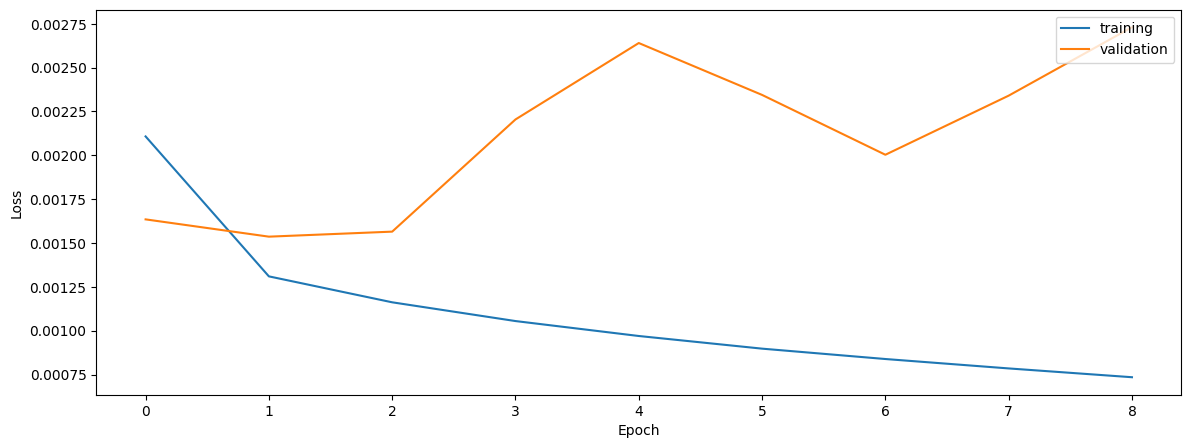

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9550543285160966
0.9574587953723573
0.947390296678321


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9550543285160966
0.9574587953723573
0.947390296678321


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9600848004575286
0.9596623968236199
0.9583552237917439


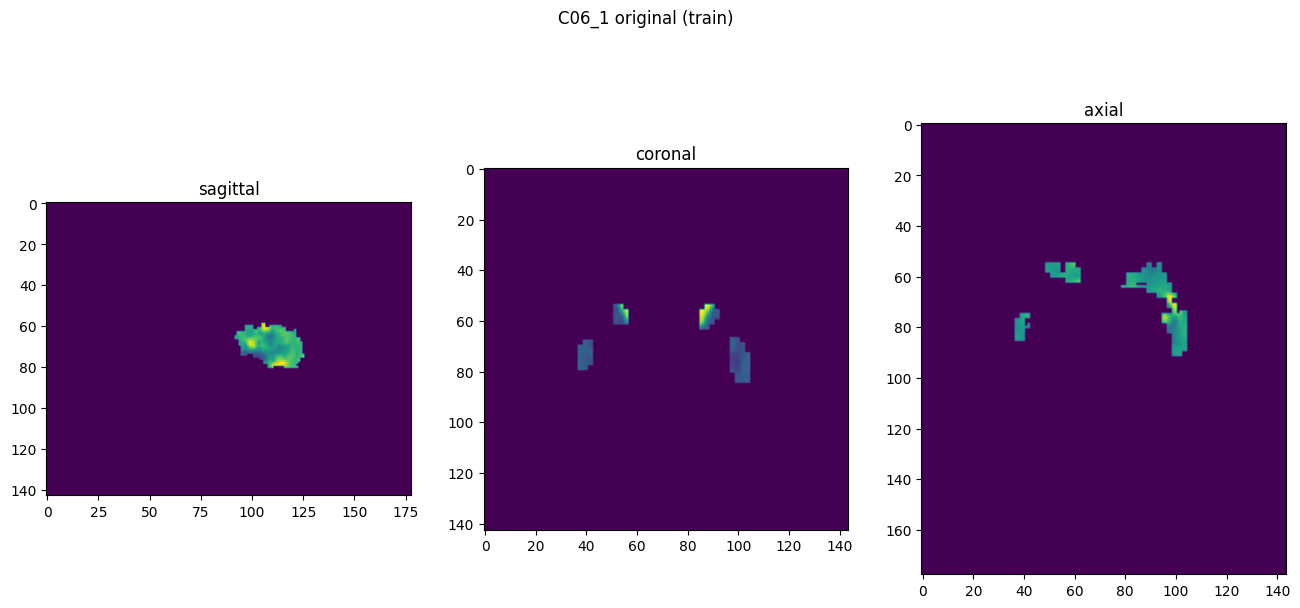

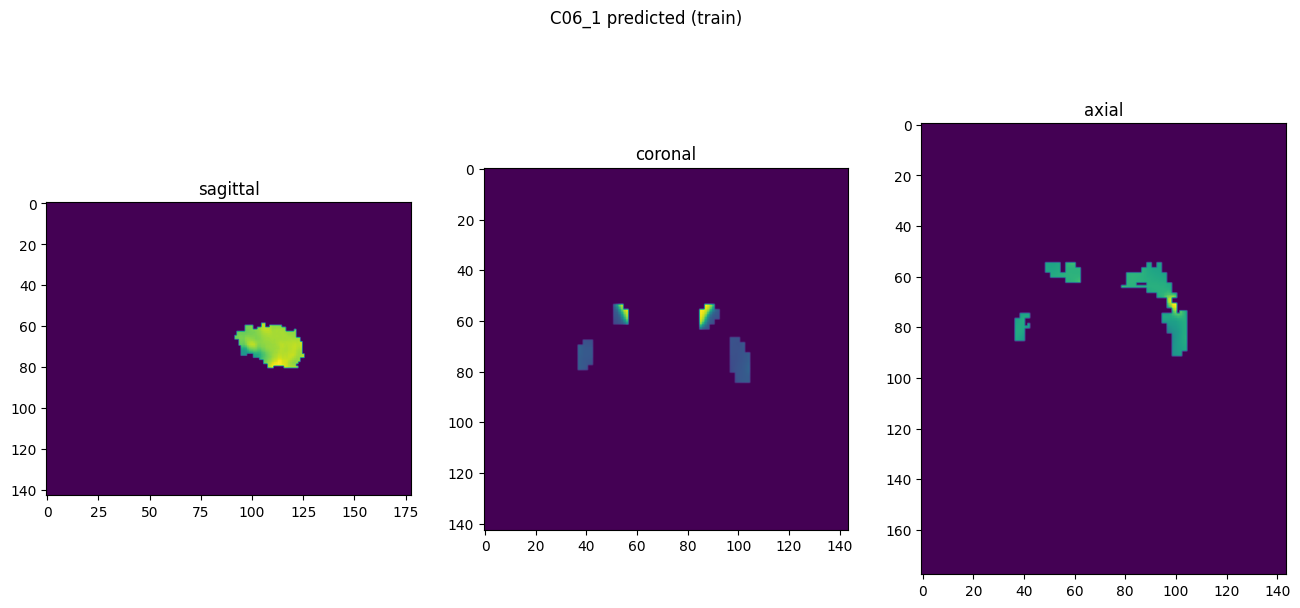

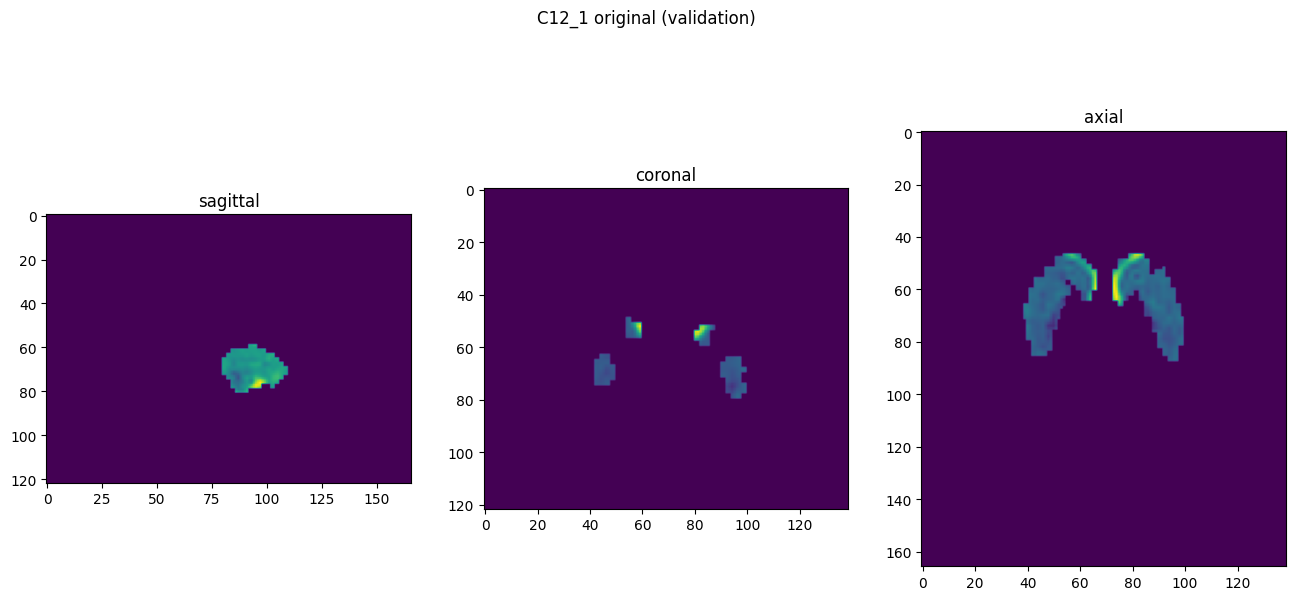

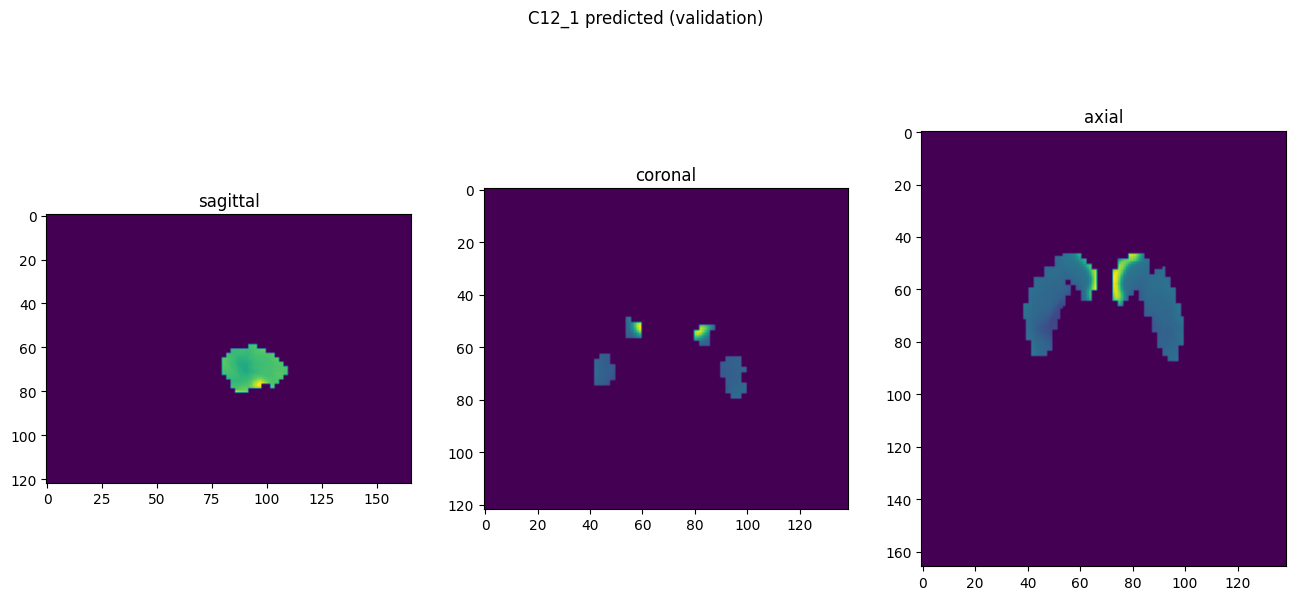

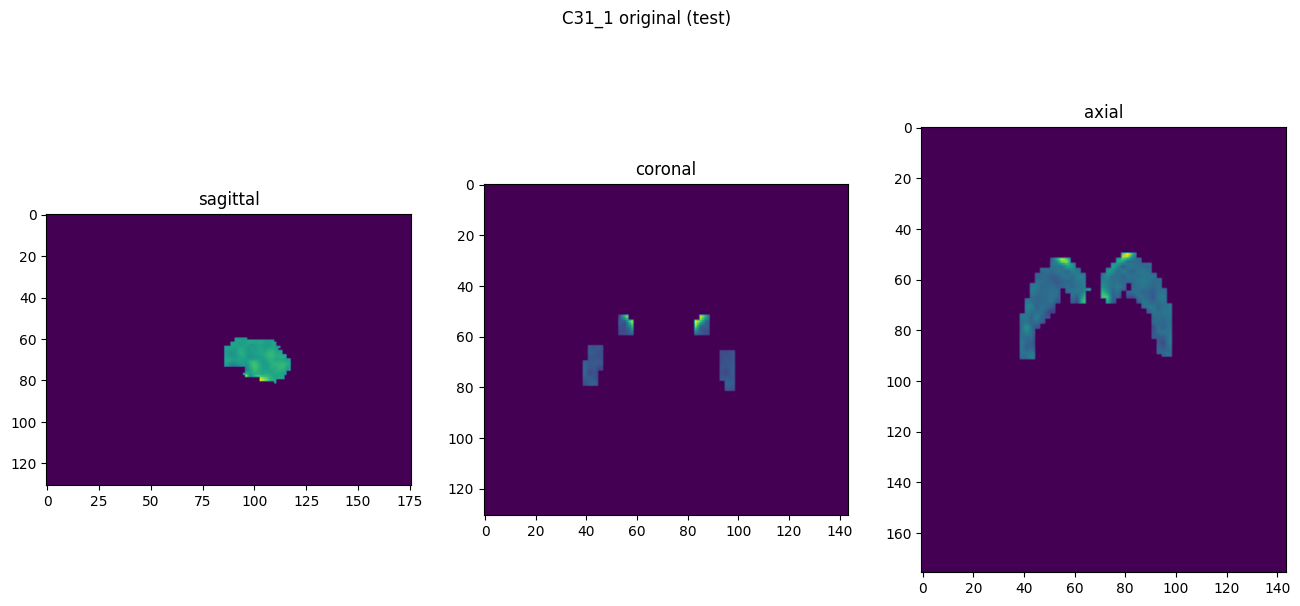

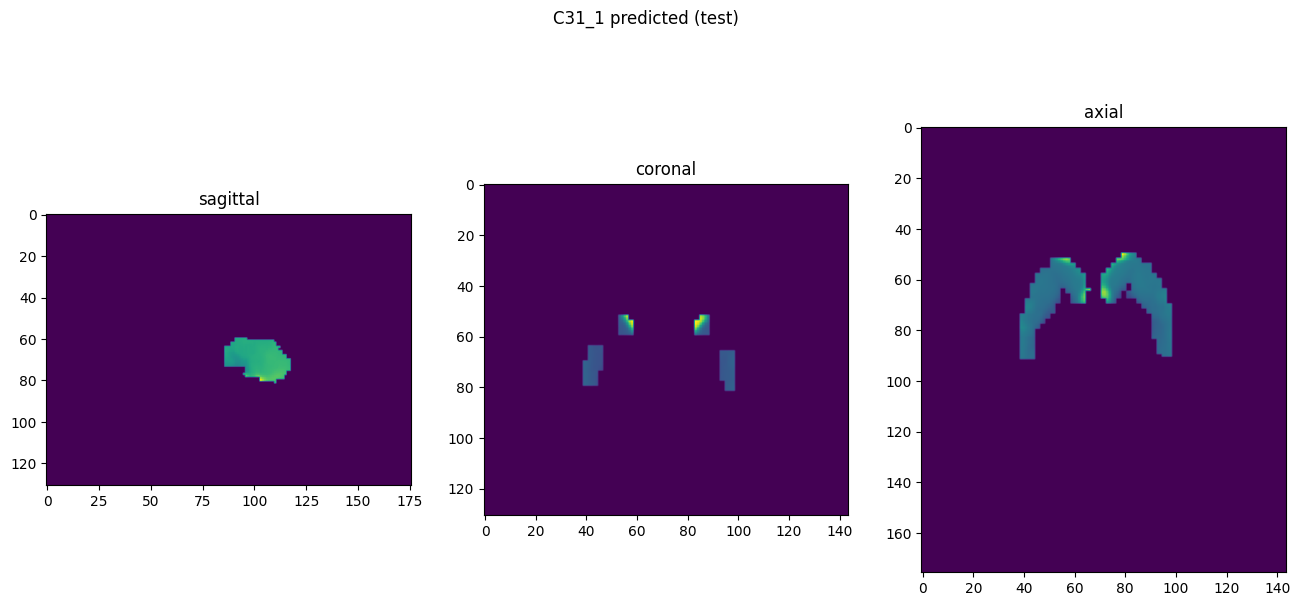

In [10]:
showResults(model, gen, threshold=None, background=False)